In [1]:
!pip install ipython-autotime;

In [2]:
!pip install darts;

# Prueba Final

### Integrantes
<small>

 - Francisca Pinto
 - Francisco Silva
 - Paula Rivera
 - Verónica Martínez
 - Benjamín Meneses
</small>

## Descripción Del Problema

## Preparación del ambiente de Trabajo

In [1]:
#tiempo de ejecución
%load_ext autotime

#dataframe y arrays
import pandas as pd
import numpy as np

#estadística
import scipy.stats as stats

#gráficos
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#gama matplotlib para facilitar escritura de código
%matplotlib inline

#separación entrenamiento validación
from sklearn.model_selection import train_test_split, GridSearchCV

#pipeline
from sklearn.pipeline import Pipeline

#Árbol de decisión de regresión
from sklearn.tree import DecisionTreeClassifier

#AdaBoost Clasiffier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#dataframe filter
import re

#AUX: montar archivos y carpetas desde Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error


from darts.metrics import rho_risk
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics.metrics import mape, mae, r2_score
from darts import concatenate


time: 4.78 s (started: 2022-03-12 16:10:39 -03:00)


In [2]:
from darts.models import ExponentialSmoothing, NBEATSModel
from darts.models.forecasting.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.utils.statistics import extract_trend_and_seasonality, remove_from_series
from darts.utils.utils import ModelMode
from scipy.stats import normaltest

Importing plotly failed. Interactive plots will not work.


time: 2.47 s (started: 2022-03-12 16:10:44 -03:00)


In [3]:
# Importamos los datos
path_items = 'items.csv'
path_sales = 'salesfact.csv'
path_salesperson = 'vendedores.csv'
path_extra = 'temperatura.csv'

df_items = pd.read_csv(path_items)
df_sales = pd.read_csv(path_sales)
df_salesperson = pd.read_csv(path_salesperson)
df_temperature = pd.read_csv(path_extra)

random_seed = 3748

time: 15 ms (started: 2022-03-12 16:10:46 -03:00)


In [4]:
df = df_sales
df['Formato'] = np.where(df['Descripción del artículo'].str.find("200 Gr")+df['Descripción del artículo'].str.find("200Gr")>=0,"200 Gr",
                np.where(df['Descripción del artículo'].str.find("1 Kg")+df['Descripción del artículo'].str.find("1Kg")>=0,"1000 Gr",
                np.where(df['Descripción del artículo'].str.find("5 Kg")+df['Descripción del artículo'].str.find("5Kg")>=0,"5000 Gr","Otro")))
df.Formato.unique()

array(['5000 Gr', '1000 Gr', '200 Gr'], dtype=object)

time: 31 ms (started: 2022-03-12 16:10:47 -03:00)


### Recodificación de columnas

Haremos un análisis de las columnas y pasaremos a refactorizar los nombres

In [5]:
# Vemos las columnas actuales
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Familia', 'Peso ( Kg )', 'InventoryUoMName',
       'InventoryValuationMethod_E', 'Es artículo de Inventario',
       'Es artículo de compras', 'Es artículo de ventas', 'ItemCode',
       'ItemDescriptionAndCode', 'Descripción del artículo', 'ItemGroupName',
       'El articulo esta activo', 'Sub - Familia'],
      dtype='object')
Ventas
Index(['Cantidad (en UM de inventario)', 'VentaNeta', 'CodCliente',
       'Número de documento', 'ItemCode', 'CodVendedor',
       'Código de almacén de línea', 'Fecha', 'Descripción del artículo',
       'CanalDeVenta', 'Kilombos', 'Formato'],
      dtype='object')
Vendedores
Index(['Active', 'Locked', 'Codigo Vendedor', 'Nombre Vendedor'], dtype='object')
time: 0 ns (started: 2022-03-12 16:10:47 -03:00)


No se borrarán de <code>Items</code> inmediato las columnas <code>Peso (kg)</code> y <code>El articulo esta activo</code> ya que:
- El peso se utilizará para sumar las filas para agrupar las ventas
- La categoría del artículo se usará para filtrar la tabla <code>Items</code>

In [6]:
df_items.drop(columns = ["Familia",
                         "InventoryUoMName",
                         "InventoryValuationMethod_E",
                         "Es artículo de Inventario",
                         "Es artículo de compras",
                         "Es artículo de ventas",
                         "ItemDescriptionAndCode",
                         "ItemGroupName",
                         "Sub - Familia"],
              inplace = True)

df_sales.drop(columns = ["Cantidad (en UM de inventario)",
                         "Código de almacén de línea",
                         "ItemCode",
                         "CanalDeVenta"],
              inplace = True)

df_salesperson.drop(columns = ["Active",
                               "Locked",
                               "Nombre Vendedor"],
                    inplace = True)

time: 0 ns (started: 2022-03-12 16:10:47 -03:00)


In [7]:
# Vemos las columnas refactorizadas
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Peso ( Kg )', 'ItemCode', 'Descripción del artículo',
       'El articulo esta activo'],
      dtype='object')
Ventas
Index(['VentaNeta', 'CodCliente', 'Número de documento', 'CodVendedor',
       'Fecha', 'Descripción del artículo', 'Kilombos', 'Formato'],
      dtype='object')
Vendedores
Index(['Codigo Vendedor'], dtype='object')
time: 16 ms (started: 2022-03-12 16:10:47 -03:00)


Luego analizaremos los productos activos filtrando la tabla <code>Items</code> por la categoría <code>El articulo esta activo</code> con etiqueta positiva, <code>Y</code>.

In [8]:
# Filtramos los productos y nos quedamos sólo con los activos
df_items = df_items[df_items['El articulo esta activo'] == 'Y']
df_items.drop(columns = ['El articulo esta activo'],inplace = True)

time: 16 ms (started: 2022-03-12 16:10:47 -03:00)


In [9]:
# Vemos como quedó el df
df_items

,Peso ( Kg ),ItemCode,Descripción del artículo
0,0.2,100402405101,Almendra Cubierta Con Chocolate De Leche Bl 20...
1,0.2,140201405101,Cranberry Entero Cubierta Chocolate Bitter Bl...
2,0.2,140202405101,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.
4,1.0,100402409101,Almendras Cubiertas Con Chocolate De Leche Bl ...
8,1.0,140201409102,Cranberry Entero Cubierta Chocolate Bitter Bl...
9,1.0,140202408102,Cranberry Cubierta Chocolate Leche Bl. 1Kg
10,1.0,140202409101,Cranberry Cubierta Chocolate Leche Bl. 5Kg
11,1.0,140203409101,Cranberry Cubierta Chocolate Blanco Bl. 5Kg
12,0.2,100401405101,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.
13,0.2,260501405101,Mani Cubierta Chocolate Bitter Bl. 200Gr.


time: 0 ns (started: 2022-03-12 16:10:47 -03:00)


Continuamos con el renombramiento final de las columnas de cada dataframe

In [10]:
def refactor(cols, df):
    newDf = df.copy()
    newDf.rename(columns = cols, inplace = True)
    return newDf

df_sales = refactor({
    'VentaNeta' : 'venta_neta',
    'CodCliente' : 'cod_cliente',
    'Número de documento' : 'num_documento',
    'Descripción del artículo' : 'description',
    'CodVendedor' : 'cod_vendedor',
    'Fecha' : 'fecha',
    'Kilombos' : 'kilos'
    }, df_sales)
df_items = refactor({
    'Peso ( Kg )' : 'peso',
    'ItemCode' : 'item_code',
    'Descripción del artículo' : 'description',
    }, df_items)
df_salesperson = refactor({'Codigo Vendedor' : 'codigo_vendedor'}, df_salesperson)
df_temperature = refactor({'Fecha' : 'fecha', 'Temperatura media Cº' : 'temperatura_media'}, df_temperature)

time: 0 ns (started: 2022-03-12 16:10:47 -03:00)


### Anonimización de Descripciones

In [11]:
# Conseguimos las descripciones unicas para ventas e listado de productos
items = np.unique(df_items['description'])
sales = np.unique(df_sales['description'])

# Vemos los productos que no están en listado de productos
registro_encontrado = []
registro_no_encontrado = []
for i in sales:
  if i in items:
    registro_encontrado.append(i)
  else:
    registro_no_encontrado.append(i)
# Imprimimos los no encontrados
print('Productos no encontrados')
print(registro_no_encontrado)

Productos no encontrados
['Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.', 'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg', 'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg', 'Mani Cubierta Chocolate Leche Bl. 1Kg.']
time: 0 ns (started: 2022-03-12 16:10:47 -03:00)


Notamos que hay Items que no están en el listado de productos

Por lo mis, la tabla <code>Items</code> no contiene la totalidad de los posibles productos a vender. Por otro lado, las descripciones de la columna <code>description</code> en la tabla <code>SalesFact</code> ya entregan la información necesaria de cada producto.

Por lo anterior, no se utilizará la tabla <code>Items</code> para continuar el procesamiento de datos, y solo se considerarán los registros de la columna <code>description</code> de <code>df_sales</code>. Se re-codificará con un diccionario.

In [12]:
df_sales.head(10)

,venta_neta,cod_cliente,num_documento,cod_vendedor,fecha,description,kilos,Formato
0,82530.0,C9233798,1017811,95,1-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0,5000 Gr
1,254117.0,C76658352,1017839,4,2-Apr-19,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0,5000 Gr
2,30252.0,C13479118,1018354,4,5-Apr-19,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0,5000 Gr
3,35294.0,C13479118,1018354,4,5-Apr-19,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0,5000 Gr
4,40757.0,C13479118,1018354,4,5-Apr-19,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,5000 Gr
5,30672.0,C76990508,1018362,11,25-Apr-19,Mani Cubierta Chocolate Bitter Bl. 5Kg,5.0,5000 Gr
6,40756.0,C76900817,1018361,11,25-Apr-19,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,5000 Gr
7,41176.0,C15257846,1018360,11,25-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,5.0,5000 Gr
8,41177.0,C76990508,1018362,11,25-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,5.0,5000 Gr
9,35714.0,C9757137,1018425,11,30-Apr-19,Cranberry Entero Cubierta Chocolate Bitter Bl...,5.0,5000 Gr


time: 16 ms (started: 2022-03-12 16:10:47 -03:00)


In [13]:
sales_description_dict = {
    "Almendra Cubierta Con Chocolate Bitter Bl 200Gr." : "AB1", 
    "Almendra Cubierta Con Chocolate De Leche Bl 200Gr." : "AL1",
    "Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg." : "AB2",
    "Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg." : "AB3",
    "Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg" : "AL2",
    "Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg" : "AL3",
    "Cranberry Cubierta Chocolate Leche Bl. 200 Gr." : "CL1",
    "Cranberry Cubierta Chocolate Leche Bl. 5Kg" : "CL3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg" : "CB2",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg" : "CB3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr." : "CB1",
    "Mani Cubierta Chocolate Bitter Bl. 200Gr." : "MB1",
    "Mani Cubierta Chocolate Bitter Bl. 5Kg" : "MB3",
    "Mani Cubierta Chocolate Leche Bl. 1Kg." : "ML2",
    "Mani Cubierta Chocolate Leche Bl. 200Gr." : "ML1",
    "Mani Cubierta Chocolate Leche Bl. 5Kg" : "ML3"
}
# Anonimizamos
df_sales['description'] = df_sales['description'].replace(sales_description_dict)
# Agregamos el grupo al que corresponden
df_sales['grupo'] = df_sales['description'].apply(lambda x: x[0:2])
#Verificamos la anonimización
print('Productos', df_sales['description'].unique())
print('Grupos', df_sales['grupo'].unique())

Productos ['AB3' 'CL3' 'ML3' 'AL3' 'MB3' 'CB3' 'AL2' 'AB1' 'ML1' 'MB1' 'CL1' 'AL1'
 'CB1' 'ML2' 'AB2' 'CB2']
Grupos ['AB' 'CL' 'ML' 'AL' 'MB' 'CB']
time: 0 ns (started: 2022-03-12 16:10:48 -03:00)


### Recodificación de atributo temporal

In [14]:
# Refactorizamos la columna fecha
df_sales['ds'] = df_sales['fecha'].apply(lambda date: pd.to_datetime(date, format='%d-%b-%y')).sort_values(ascending=True)
df_sales['ds-monthYear'] = df_sales['ds'].dt.strftime('%Y-%m')
df_sales['ds-weekYear'] = df_sales['ds'].dt.strftime('%Y-%U')
df_sales.drop(columns = ['fecha'],
              inplace = True)

time: 750 ms (started: 2022-03-12 16:10:48 -03:00)


### Recodificación de tipos de datos

In [15]:
df_sales.venta_neta.astype('float64')
df_sales.cod_cliente.astype('str')
df_sales.num_documento.astype('int32')
df_sales.cod_vendedor.astype('int32')
df_sales.description.astype('str')
df_sales.kilos.astype('float64')
df_temperature.fecha = pd.to_datetime(df_temperature['fecha'], format = '%d/%m/%Y')
df_temperature.temperatura_media.astype('float64');

time: 0 ns (started: 2022-03-12 16:10:48 -03:00)


In [16]:
 # Comprobamos la asignación correcta de tipos de dato por columna
df_sales.dtypes

venta_neta              float64
cod_cliente              object
num_documento             int64
cod_vendedor              int64
description              object
kilos                   float64
Formato                  object
grupo                    object
ds               datetime64[ns]
ds-monthYear             object
ds-weekYear              object
dtype: object

time: 0 ns (started: 2022-03-12 16:10:49 -03:00)


In [17]:
df_temperature.dtypes

fecha                datetime64[ns]
temperatura_media           float64
dtype: object

time: 0 ns (started: 2022-03-12 16:10:49 -03:00)


### Análisis de datos anómalos

#### Datos Anómalos

In [18]:
# Verificamos que quedaron anonimizadas
df_sales.groupby(['description']).size()

description
AB1     113
AB2       1
AB3    1196
AL1      91
AL2       1
AL3     844
CB1     119
CB2       1
CB3    1481
CL1      83
CL3     743
MB1      94
MB3     991
ML1      97
ML2       1
ML3     842
dtype: int64

time: 0 ns (started: 2022-03-12 16:10:49 -03:00)


In [19]:
# Eliminamos los que aparecen una vez
df_clean = df_sales[~df_sales['description'].isin(['AL2', 'AB2', 'ML2', 'CB2'])]
df_clean.groupby(['description']).size()

description
AB1     113
AB3    1196
AL1      91
AL3     844
CB1     119
CB3    1481
CL1      83
CL3     743
MB1      94
MB3     991
ML1      97
ML3     842
dtype: int64

time: 0 ns (started: 2022-03-12 16:10:49 -03:00)


#### Anulaciones

In [20]:
# Definición de anulaciones: kilos de transacción menores a 0
df_sales_cancelled = df_clean[df_clean['kilos'] < 0]
print('Anulaciones', '\nCantidad de anulaciones:', df_sales_cancelled.shape[0], '\nCantidad de num_documento de anulaciones (operaciones por comprador): ', len(np.unique(df_sales_cancelled['num_documento'])))
print(df_sales_cancelled['kilos'].describe())
print(df_sales_cancelled['kilos'].sum())
df_clean[df_clean['kilos'] > 0]['kilos'].sum()

Anulaciones 
Cantidad de anulaciones: 103 
Cantidad de num_documento de anulaciones (operaciones por comprador):  52
count    103.000000
mean     -11.209709
std       17.111088
min     -100.000000
25%      -10.000000
50%       -5.000000
75%       -5.000000
max       -0.200000
Name: kilos, dtype: float64
-1154.6


63425.40000000001

time: 16 ms (started: 2022-03-12 16:10:49 -03:00)


Notamos que hay 103 registros de devolución, repartidas en 52 documentos distintos. Creemos entonces que lo mejor es dejar estos datos 

#### Outliers

Para la identificación de outliers usaremos la media y desviación estandar MENSUAL usando todos los productos. Haremos el análisis de outliers para 1, 3, 5 y 7 desviaciones estandar respecto de la media.

In [25]:
[1, 2, 3][0:2]

[1, 2]

time: 16 ms (started: 2022-03-12 16:26:33 -03:00)


In [44]:
def getOutlier(df, std_multiplier = 1, window_size= 31):
    def checkOutlier(x, mean, std, steps):
        if(x > mean + steps * std or x < mean - steps * std):
            return 1
        else:
            return 0
    current_index = 0
    differentDays = df.sort_values(by = 'ds')['ds'].unique()

    df_filtered = df.copy()
    outlier_label = f'outlier-{std_multiplier}'
    df_filtered[outlier_label] = 0

    while current_index + window_size < len(differentDays):
        # Conseguimos los días de la ventana
        daysInWindow = differentDays[current_index : current_index + window_size]
        dayToFilter = daysInWindow[-1] # El último día de la ventana
        # Conseguimos los datos que pertenezcan a la ventana
        df_aux = df_filtered[df_filtered['ds'].isin(daysInWindow) & df_filtered[outlier_label] == 0]
        # Calculamos la media y la desviación estándar de la ventana
        mean = df_aux['kilos'].mean()
        std = df_aux['kilos'].std()
        df_to_filter = df_aux[df_aux['ds'] == dayToFilter]
        # Calculamos los valores que están por encima de la media + std
        for i, row in df_to_filter.iterrows():
            df_filtered.at[i, outlier_label] = checkOutlier(row['kilos'], mean, std, std_multiplier)
        current_index += 1
    return df_filtered[outlier_label]

time: 0 ns (started: 2022-03-12 17:05:11 -03:00)


In [48]:
df_clean['outlier-1'] = getOutlier(df_clean, std_multiplier = 1)
df_clean['outlier-2'] = getOutlier(df_clean, std_multiplier = 2)
df_clean['outlier-5'] = getOutlier(df_clean, std_multiplier = 5)
df_clean['outlier-7'] = getOutlier(df_clean, std_multiplier = 7)

time: 7.52 s (started: 2022-03-12 17:05:53 -03:00)


In [21]:
# Identificamos la media y desviacion estandar por Mes
df_sales_weekly = df_clean.groupby(['ds-monthYear']).agg({'kilos' : ['mean', 'std']})
df_sales_weekly.columns = ['mean', 'std']
df_sales_weekly.reset_index(inplace = True)
# Creamos un hash para identificar los meses
weeks = {}
for i, series in df_sales_weekly.iterrows():
    if(series['ds-monthYear'] not in weeks.keys()):
        weeks[series['ds-monthYear']] = {}
    weeks[series['ds-monthYear']] = {
        'mean' : series['mean'],
        'std' : series['std']
    }
def checkOutlier(x, mean, std, steps):
    if(x > mean + steps * std or x < mean - steps * std):
        return 1
    else:
        return 0
# Marcamos los valores que no cumplen con la media y desviacion estandar
for i, row in df_clean.iterrows():
    mean = weeks[row['ds-monthYear']]['mean']
    std = weeks[row['ds-monthYear']]['std']
    if row['ds-monthYear'] in weeks:
        df_clean.at[i, 'outlier-1'] = checkOutlier(row['kilos'], mean, std, 1)
        df_clean.at[i, 'outlier-2'] = checkOutlier(row['kilos'], mean, std, 2)
        df_clean.at[i, 'outlier-5'] = checkOutlier(row['kilos'], mean, std, 5)
        df_clean.at[i, 'outlier-7'] = checkOutlier(row['kilos'], mean, std, 7)
    else:
        print('Semana no encontrada', row['ds-monthYear'])
        df_clean.at[i, 'outlier-1'] = 1
        df_clean.at[i, 'outlier-2'] = 1
        df_clean.at[i, 'outlier-5'] = 1
        df_clean.at[i, 'outlier-7'] = 1


time: 891 ms (started: 2022-03-12 16:10:49 -03:00)


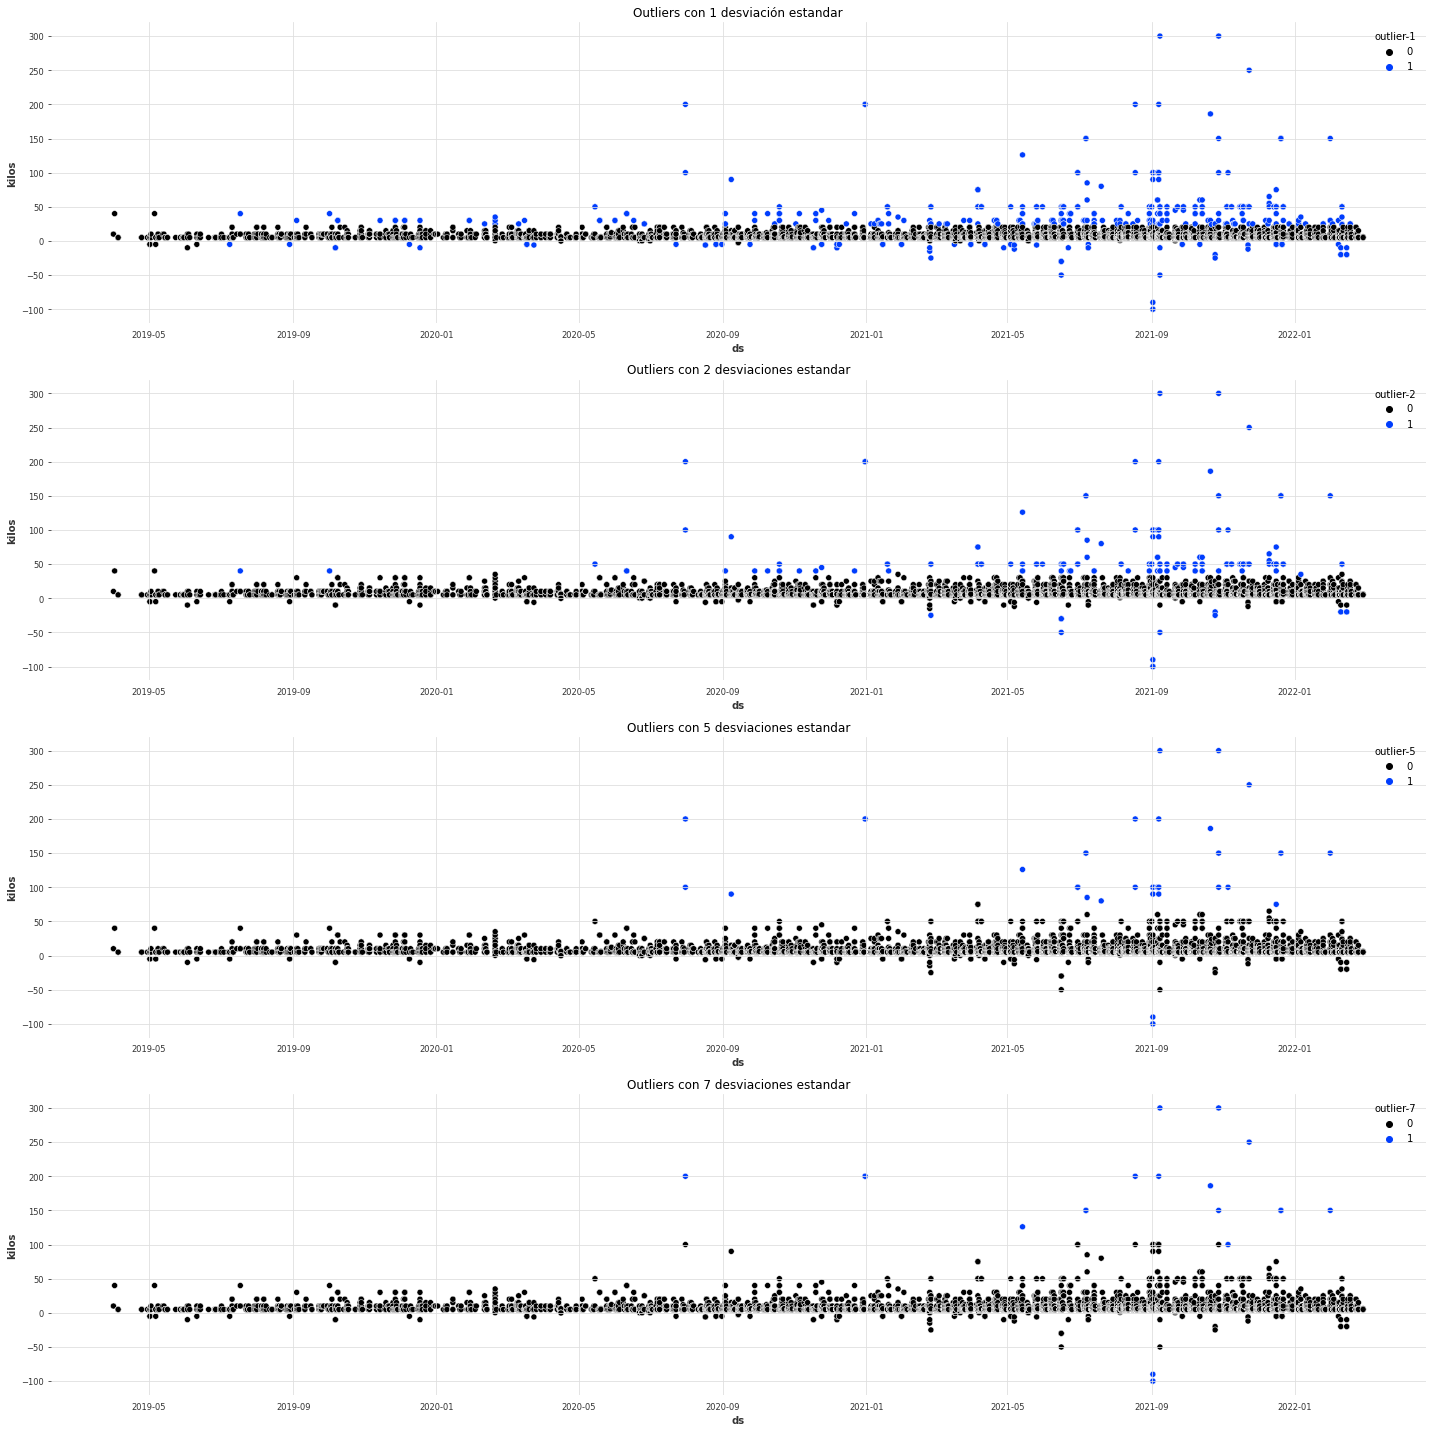

time: 2.11 s (started: 2022-03-12 17:06:01 -03:00)


In [49]:
# Graficamos los outliers en la serie de kilos
fig, ax = plt.subplots(4, 1,figsize=(20,20))
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-1'], ax=ax[0])
ax[0].set_title('Outliers con 1 desviación estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-2'], ax=ax[1])
ax[1].set_title('Outliers con 2 desviaciones estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-5'], ax=ax[2])
ax[2].set_title('Outliers con 5 desviaciones estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-7'], ax=ax[3])
ax[3].set_title('Outliers con 7 desviaciones estandar', fontsize=12)
plt.tight_layout()

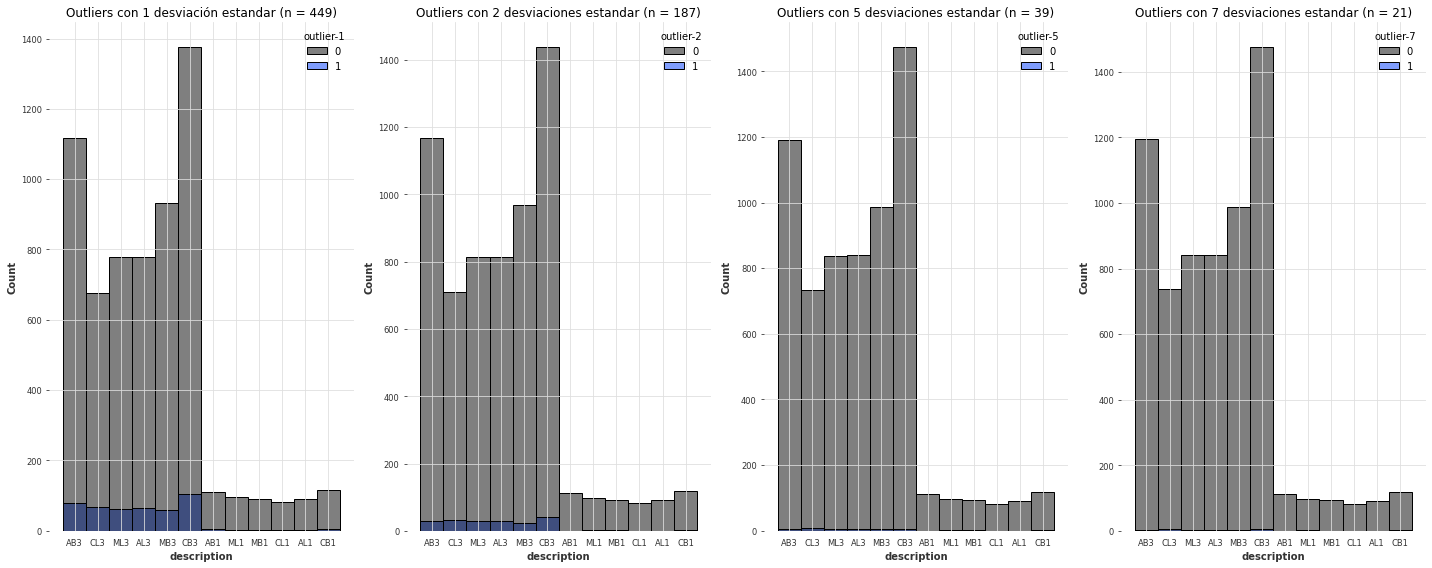

time: 1.06 s (started: 2022-03-12 17:13:54 -03:00)


In [52]:
# Graficamos el histograma de items con outliers
fig, ax = plt.subplots(1, 4,figsize=(20,8))
sns.histplot(data=df_clean, x='description', hue='outlier-1', ax=ax[0])
ax[0].set_title(f'Outliers con 1 desviación estandar (n = {df_clean[df_clean["outlier-1"] == 1].shape[0]})', fontsize=12)
sns.histplot(data=df_clean, x='description', hue='outlier-2', ax=ax[1])
ax[1].set_title(f'Outliers con 2 desviaciones estandar (n = {df_clean[df_clean["outlier-2"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-5', ax=ax[2])
ax[2].set_title(f'Outliers con 5 desviaciones estandar (n = {df_clean[df_clean["outlier-5"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-7', ax=ax[3])
ax[3].set_title(f'Outliers con 7 desviaciones estandar (n = {df_clean[df_clean["outlier-7"] == 1].shape[0]})')
plt.tight_layout()

Usaremos entonces 7 desviaciones estandar desde la media para identificar outliers

In [51]:
# Vemos la distriución de datos sacados de la serie de kilos
df_clean['outlier-7'].value_counts()

0    6673
1      21
Name: outlier-7, dtype: int64

time: 0 ns (started: 2022-03-12 17:12:32 -03:00)


In [53]:
#Sacamos los outliers
df_clean_outliers = df_clean[df_clean['outlier-7'] == 0]

time: 0 ns (started: 2022-03-12 17:15:11 -03:00)


#### Filtrado de datos

Para mejorar nuestros modelos, hemos decidido sólo incluir la información desde Marzo 2020 en adelante. Esto debido a que el comportamiento del canal de televentas cambió drásticamente posterior esta fecha, debido a la pandemia y el distanciamento social, por lo que quitar los datos previos tiene sentido para nosotros y el cliente.

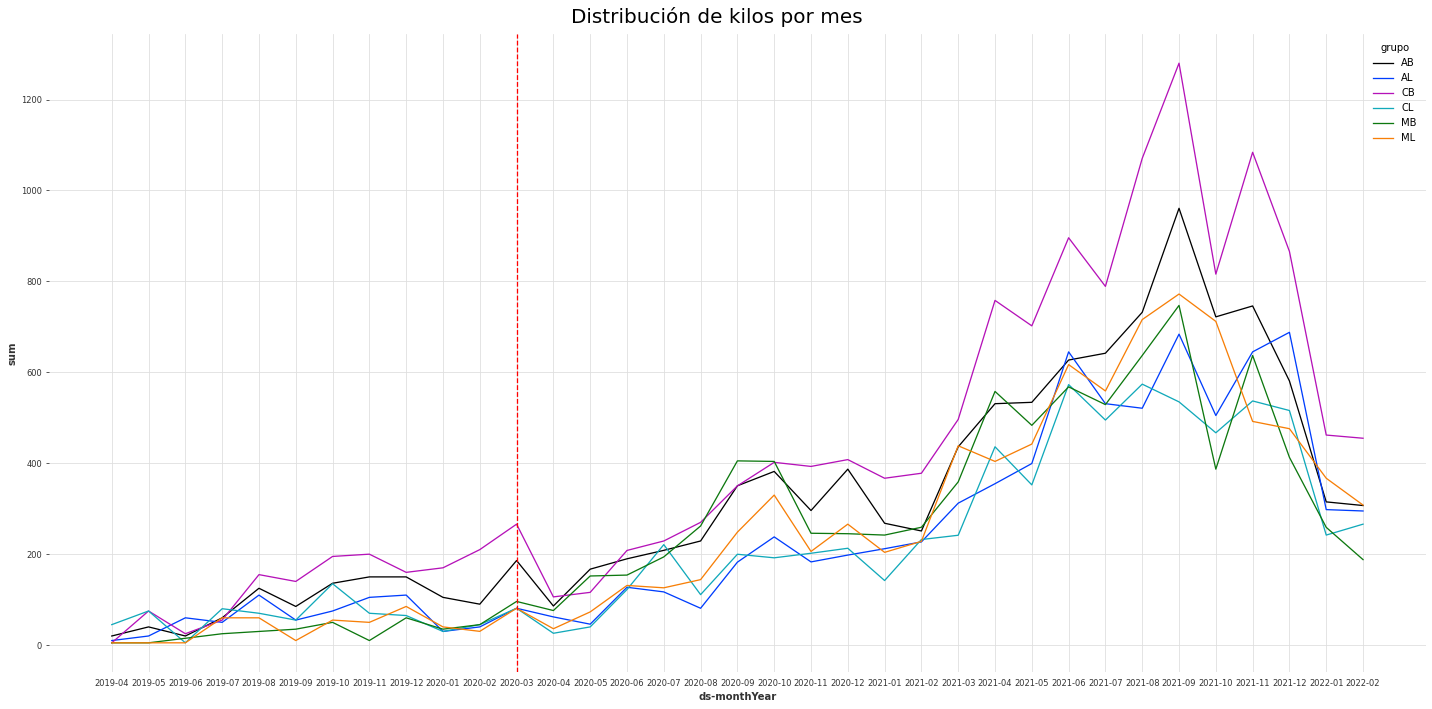

time: 750 ms (started: 2022-03-12 17:15:17 -03:00)


In [54]:
df_grouped_monthly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-monthYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_monthly.columns = ['sum']
df_grouped_monthly.reset_index(inplace = True)
plt.figure(figsize=(20,10))
sns.lineplot(data=df_grouped_monthly, x='ds-monthYear', y='sum', hue='grupo')
plt.suptitle('Distribución de kilos por mes', fontsize=20)
plt.axvline(x='2020-03', color='r', linestyle='--')
plt.tight_layout()

In [55]:
# Dejamos sólo los datos de Marzo 2020 en adelante
df_clean_outliers = df_clean_outliers[df_clean_outliers['ds'] >= pd.to_datetime('2020-03-01')]

time: 0 ns (started: 2022-03-12 17:15:21 -03:00)


Agrupación

In [57]:
# Transformamos las fechas de cada semana a pd.Int64Index
def convertWeeklyIndex(df):
    cols = [*df.columns, 'month', 'year', 'weekOfYear']
    intDf = pd.DataFrame(columns=cols)
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2020
    semana = 9
    index = 1
    debugLabels = []
    while True:
        cero = '0' if semana < 10 else ''
        label = f'{año}-{cero}{semana}'
        fecha = pd.to_datetime(f'{label}-6', format='%Y-%U-%w')
        month = fecha.month
        year = fecha.year
        weekOfYear = fecha.strftime('%U')
        if label in df.index:
            intDf.at[index] = [*df.loc[label, :], *[month, year, weekOfYear]]
            debugLabels.append(label)
        else:
            print('weekly No encontrado', label, index)
            intDf.at[index] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, month, year, weekOfYear]
        if label == '2022-09':
            break
        index += 1
        semana += 1
        if semana > 52:
            año += 1
            if año == 2020:
                semana = 0
            else:
                semana = 1
    # Creamos un nuevo DataFrame con las fechas de las semanas
    newIndex = pd.RangeIndex(0, index)
    try :
        intDf.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intDf

# Transformamos las fechas de cada semana a pd.Int64Index
def convertMonthlyIndex(df):
    cols = [*df.columns, 'month', 'year']
    intDf = pd.DataFrame(columns=cols)
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2020
    mes = 3
    index = 1
    indexes = []
    debugLabels = []
    while True:
        cero = '0' if mes < 10 else ''
        label = f'{año}-{cero}{mes}'
        if label in df.index:
            intDf.at[index] = [*df.loc[label, :], *[mes, año]]
            debugLabels.append(label)
        else:
            print('monthly No encontrado', label, index)
            intDf.at[index] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, mes, año]
        if label == '2022-02':
            break
        index += 1
        mes += 1
        if mes > 12:
            mes = 1
            año += 1
    # Creamos un nuevo DataFrame con las fechas de las semanas
    newIndex = pd.RangeIndex(0, index)
    try :
        intDf.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intDf

time: 0 ns (started: 2022-03-12 17:15:26 -03:00)


In [58]:
def preprocessSeries(subDf, freq = 'D', cols = ['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median']):
    filler = MissingValuesFiller(fill=0.)
    #Instanciamos
    itemTimeSeries = TimeSeries.from_dataframe(subDf, None, value_cols=cols, freq=freq)
    # Completamos valores faltantes
    itemTimeSeries = filler.transform(itemTimeSeries)
    # Separamos los datos en train y test
    train, test = itemTimeSeries.split_before(0.8)
    # Separamos las covariantes
    scaled_train_covs = concatenate(
        [
            train['kilos_max'],
            train['kilos_std'],
            train['kilos_median'],
        ],
        axis="component",
    )
    scaled_test_covs = concatenate(
        [
            test['kilos_max'],
            test['kilos_std'],
            test['kilos_median'],
        ],
        axis="component",
    )
    return {
        'df': subDf,
        'series': itemTimeSeries,
        'train': {
            'target': train['kilos_sum'],
            'past_covars': scaled_train_covs,
        },
        'test': {
            'target': test['kilos_sum'],
            'past_covars': scaled_test_covs,
        }
    }

time: 0 ns (started: 2022-03-12 17:15:28 -03:00)


#### Agrupaciones temporales

Se generarán los conjuntos de datos considerando:
1. División temporal con totalidad de productos: agrupación diaria, semanal y mensual.
2. División temporal por producto: considerando los 6 tipos de producto, se realizarán las mismas agrupaciones temporales de 1.

In [59]:
# Agrupamos según fecha y grupo
groupedDailyDf = df_clean_outliers.groupby(['ds', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedDailyDf.columns = ['_'.join(col).strip() for col in groupedDailyDf.columns.values]
# Creamos un diccionario para guardar las series
series = {}
# Conseguimos según grupo
for itemCode in groupedDailyDf.index.get_level_values(1).unique():
    subDf = groupedDailyDf[groupedDailyDf.index.get_level_values(1) == itemCode].sort_values(by='ds')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        subDf = subDf.astype(float)
        processed_series = preprocessSeries(subDf, freq='D')
        # Agregamos los datos al diccionario
        series[itemCode] = processed_series
# Conseguimos los totales
groupedTotalDailyDf = df_clean_outliers.groupby(['ds']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalDailyDf.columns = ['_'.join(col).strip() for col in groupedTotalDailyDf.columns.values]
groupedDailyDf = groupedTotalDailyDf.astype(float)
series['total'] = preprocessSeries(groupedTotalDailyDf, freq='D')


time: 156 ms (started: 2022-03-12 17:15:31 -03:00)


In [60]:
# Agrupamos por semana y grupo
groupedWeeklyDf = df_clean_outliers.groupby(['ds-weekYear', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedWeeklyDf.columns = ['_'.join(col).strip() for col in groupedWeeklyDf.columns.values]
# Iteramos por los grupos
weekly_series = {}
for itemCode in groupedWeeklyDf.index.get_level_values(1).unique():
    subDf = groupedWeeklyDf[groupedWeeklyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-weekYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertWeeklyIndex(subDf).astype(float)
        processed_series = preprocessSeries(subDf, freq='W', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year', 'weekOfYear'])
        # Agregamos los datos al diccionario
        weekly_series[itemCode] = processed_series
# Agrupamos los totales semana
groupedTotalWeeklyDf = df_clean_outliers.groupby(['ds-weekYear']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalWeeklyDf.columns = ['_'.join(col).strip() for col in groupedTotalWeeklyDf.columns.values]
# Convertimos a pd.Int64Index
groupedTotalWeeklyDf = convertWeeklyIndex(groupedTotalWeeklyDf).astype(float)
# Agregamos los datos al diccionario
weekly_series['total'] = preprocessSeries(groupedTotalWeeklyDf, freq='W', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year', 'weekOfYear'])

weekly No encontrado 2020-17 9
weekly No encontrado 2022-09 105
weekly No encontrado 2020-18 10
weekly No encontrado 2020-17 9
weekly No encontrado 2022-09 105
weekly No encontrado 2020-09 1
weekly No encontrado 2020-12 4
weekly No encontrado 2020-14 6
weekly No encontrado 2020-16 8
weekly No encontrado 2022-09 105
weekly No encontrado 2020-09 1
weekly No encontrado 2020-14 6
time: 609 ms (started: 2022-03-12 17:15:32 -03:00)


In [61]:
# Agrupamos según mes y grupo
groupedMonthlyDf = df_clean_outliers.groupby(['ds-monthYear', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedMonthlyDf.columns = ['_'.join(col).strip() for col in groupedMonthlyDf.columns.values]
monthly_series = {}
for itemCode in groupedMonthlyDf.index.get_level_values(1).unique():
    subDf = groupedMonthlyDf[groupedMonthlyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-monthYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertMonthlyIndex(subDf).astype(float)
        processed_series = preprocessSeries(subDf, freq='M', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year'])
        # Agregamos los datos al diccionario
        monthly_series[itemCode] = processed_series
# Agrupamos los totales semana
groupedTotalMonthlyDf = df_clean_outliers.groupby(['ds-monthYear']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalMonthlyDf.columns = ['_'.join(col).strip() for col in groupedTotalMonthlyDf.columns.values]
# Convertimos a pd.Int64Index
groupedTotalMonthlyDf = convertMonthlyIndex(groupedTotalMonthlyDf).astype(float)
# Agregamos los datos al diccionario
monthly_series['total'] = preprocessSeries(groupedTotalMonthlyDf, freq='M', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year'])


time: 172 ms (started: 2022-03-12 17:15:35 -03:00)


### Variables Exogenas

#### Temperatura
Fuente: Dirección General de Aeronáutica Civil (DGAC), Dirección Meteorológica de Chile, Servicios Climáticos, temperatura media diaria en grados Celsius de Estación Quinta Normal (Región Metropolitana).

Diario: temperatura
Semanal y mensual: promedio de temperatura media de días correspondientes.

In [ ]:
df_temperature[df_temperature.index > pd.to_datetime('2020-03-01')]

,temperatura_media
fecha,
2020-03-02,20.7
2020-03-03,21.3
2020-03-04,21.5
2020-03-05,23.9
2020-03-06,23.0
...,...
2021-12-27,22.8
2021-12-28,22.0
2021-12-29,17.7


time: 16 ms (started: 2022-03-12 14:16:56 -03:00)


In [ ]:
df_temperature_week = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'W-MON', label = 'left')])['temperatura_media'].mean())
df_temperature_month = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'M', label = 'left')])['temperatura_media'].mean())

time: 0 ns (started: 2022-03-12 13:47:03 -03:00)


In [ ]:
#df_temperature_week y df_temperature_week ya tienen fecha como índice por la agrupación de la celda anterior
df_temperature.set_index('fecha', inplace = True)

time: 0 ns (started: 2022-03-12 13:47:03 -03:00)


In [ ]:
df_temperature['temperatura_media'] = df_temperature['temperatura_media'].astype(float)

time: 0 ns (started: 2022-03-12 13:47:03 -03:00)


In [ ]:
df_temp_corr = pd.DataFrame()
df_temp_corr['temperatura_media'] = df_temperature_week['temperatura_media']
df_temp_corr['total_sum'] = weekly_series['total']['df']['kilos_sum']

time: 0 ns (started: 2022-03-12 14:04:32 -03:00)


In [ ]:
df_temp_corr.tail()

,temperatura_media,total_sum
fecha,,
2021-11-29,19.542857,NaN
2021-12-06,18.242857,NaN
2021-12-13,20.857143,NaN
2021-12-20,22.685714,NaN
2021-12-27,20.700000,NaN


time: 0 ns (started: 2022-03-12 14:04:45 -03:00)


## Exploratorio

### Análisis de correlación cruzada

<AxesSubplot:>

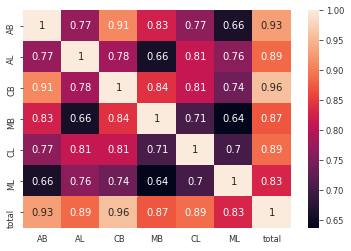

time: 562 ms (started: 2022-03-12 17:15:43 -03:00)


In [62]:
df_all_series = pd.DataFrame()
for key in weekly_series.keys():
  df_all_series[key] = weekly_series[key]['df']['kilos_sum']

sns.heatmap(df_all_series.corr(), annot=True)


Notamos que para casi todos las series por grupo tienen una correlación > ~0.9 respecto de la serie total, lo que nos permite ajustar nuestros modelos respecto a la serie total (con todos los productos) y replicarlos para cada grupo posteriormente.

### Exploración de las series

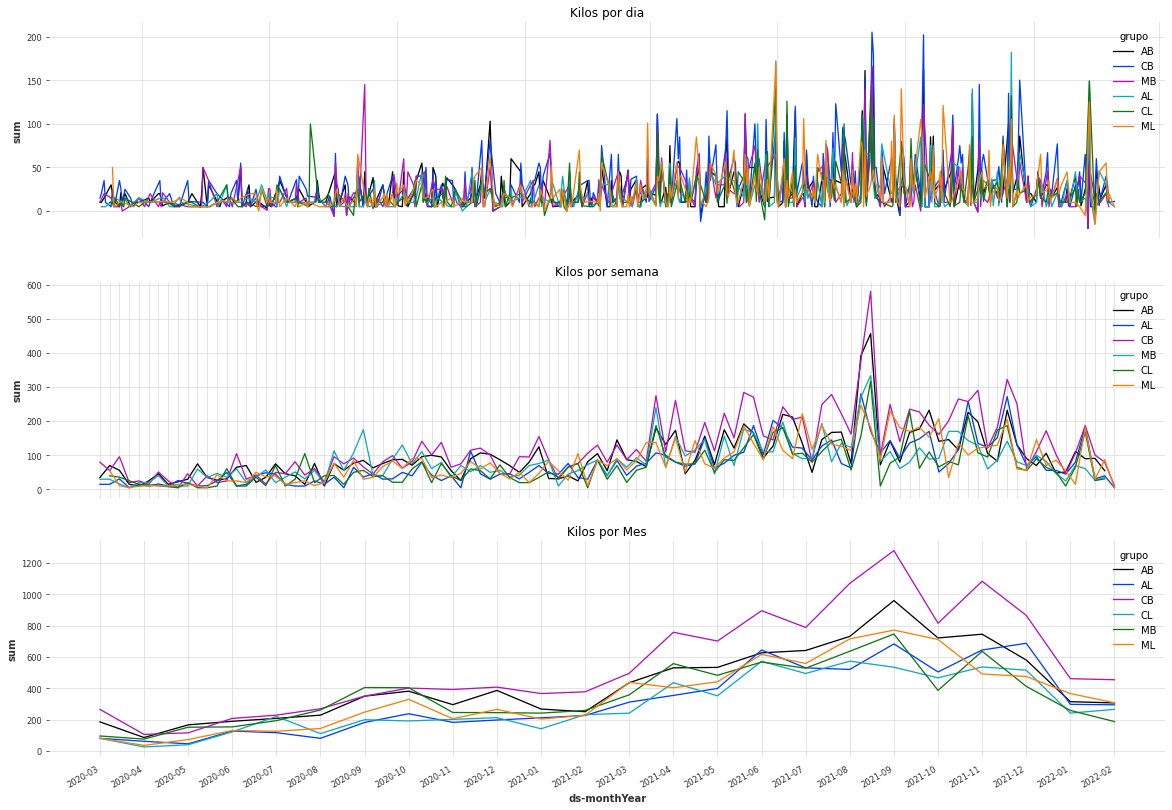

time: 1.3 s (started: 2022-03-12 17:16:14 -03:00)


In [63]:
fig, ax = plt.subplots(3, 1,figsize=(20,15))
df_grouped_daily = df_clean_outliers.sort_values(by=['ds']).groupby(['ds', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_daily.columns = ['sum']
df_grouped_daily.reset_index(inplace = True)

df_grouped_weekly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-weekYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_weekly.columns = ['sum']
df_grouped_weekly.reset_index(inplace = True)

df_grouped_monthly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-monthYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_monthly.columns = ['sum']
df_grouped_monthly.reset_index(inplace = True)

sns.lineplot(data=df_grouped_daily, x='ds', y='sum', hue='grupo', ax=ax[0])
sns.lineplot(data=df_grouped_weekly, x='ds-weekYear', y='sum', hue='grupo', ax=ax[1])
sns.lineplot(data=df_grouped_monthly, x='ds-monthYear', y='sum', hue='grupo', ax=ax[2])
ax[0].set_title('Kilos por dia')
ax[1].set_title('Kilos por semana')
ax[2].set_title('Kilos por Mes')
fig.autofmt_xdate()

La grupación semanal tiene una cantidad de periodos sin venta proporcionalmente mucho menor a los conjuntos de datos diarios, y se acerca al objetivo del cliente: estimar mensualmente el stock de los productos. Por lo anterior, se continuará trabajando con esta temporalidad.

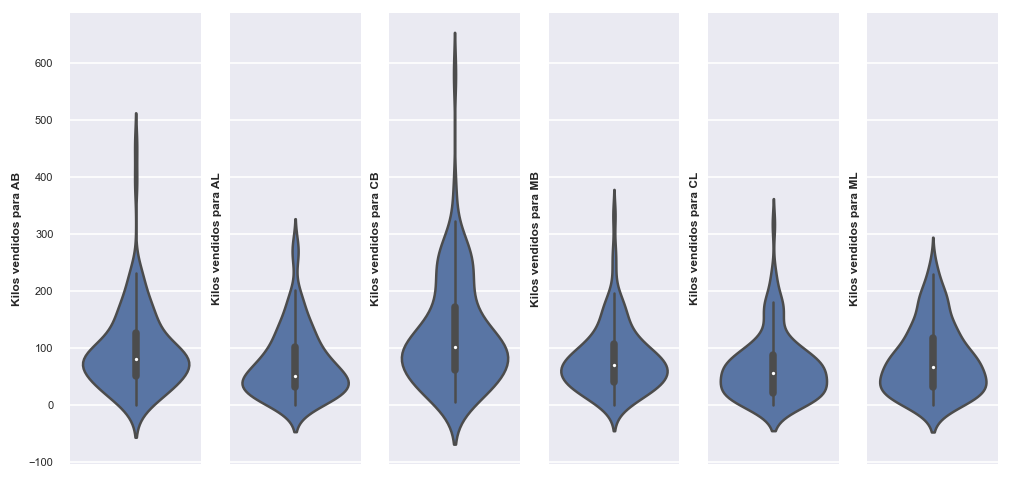

time: 438 ms (started: 2022-03-12 17:16:16 -03:00)


In [64]:
sns.set(font_scale = 0.6)
plt.rcParams["figure.dpi"] = 120
fig, ax = plt.subplots(1, 6, figsize=(10, 5), sharey=True)
for n, i in enumerate(weekly_series.keys()):
    if i == 'total':
        continue
    axis = ax[n]
    df = weekly_series[i]['df']
    sns.violinplot(data = df, y = df['kilos_sum'], ax=axis)
    axis.set_ylabel(f'Kilos vendidos para {i}')

Respecto a la dsitribución de los datos:

- Los productos A y B de primer tipo (productos 1 y 3) tienen mayor dispersión de venta. Son además los productos con menor cantidad de periodos sin venta, según las cifras anteriores.
- Los productos C de ambos tipos son los que tienen, en conjunto, una mayor concentración en valores bajos. Son también los que presentan mayor cantidad de periodos con venta 0.
- A pesar de la dispersión, el tercer cuartil solo supera los 100 kilos de venta semanal en el producto 3, mostrando una concentración de ventas de esta magnitud, o menor.
- Se observa que los productos 2, 4 y 6 (tipo B) tienden a tener ventas de menor volumen.

In [65]:
from scipy.stats import skew, kurtosis

for n, i in enumerate(weekly_series.keys()):
    df = weekly_series[i]['df']
    print(f'Conjunto de datos {i}, coeficiente de asimetría: ', round(skew(df['kilos_sum']), 2), '| Curtosis: ', round(kurtosis(df['kilos_sum']), 2))

Conjunto de datos AB, coeficiente de asimetría:  2.05 | Curtosis:  6.8
Conjunto de datos AL, coeficiente de asimetría:  1.33 | Curtosis:  1.77
Conjunto de datos CB, coeficiente de asimetría:  1.57 | Curtosis:  4.09
Conjunto de datos MB, coeficiente de asimetría:  1.52 | Curtosis:  3.42
Conjunto de datos CL, coeficiente de asimetría:  1.51 | Curtosis:  2.99
Conjunto de datos ML, coeficiente de asimetría:  0.79 | Curtosis:  -0.17
Conjunto de datos total, coeficiente de asimetría:  1.34 | Curtosis:  2.54
time: 0 ns (started: 2022-03-12 17:16:18 -03:00)


Respecto al coeficiente de asimetría y curtosis (Fischer) para los conjuntos semanales, se tiene:
- Todos los coeficientes de asimetría son mayores a 0: todas las distribuciones tienen concentración de valores mayores a la media, que es empujada con ciertos valores de anulaciones y ventas bajas. La asimetría de la curva total es cercana a 1.5, recogiendo la variabilidad de todos los productos.
- En relación a la curtosis, todos los índices son mayores a 0: las curvas son leptocúrticas, con una gran concentración de valores en las cercanías a la media de cada producto. Existen diferencias importantes entre productos: en el caso del producto BB presenta la curtosis más cercana a 0, más parecida a una distribución normal, y el caso contrario es el AA, con una curva muy levantada.


## Análisis relacionados con series de tiempo

Importación de librerías para gráficos ACF Y PACF

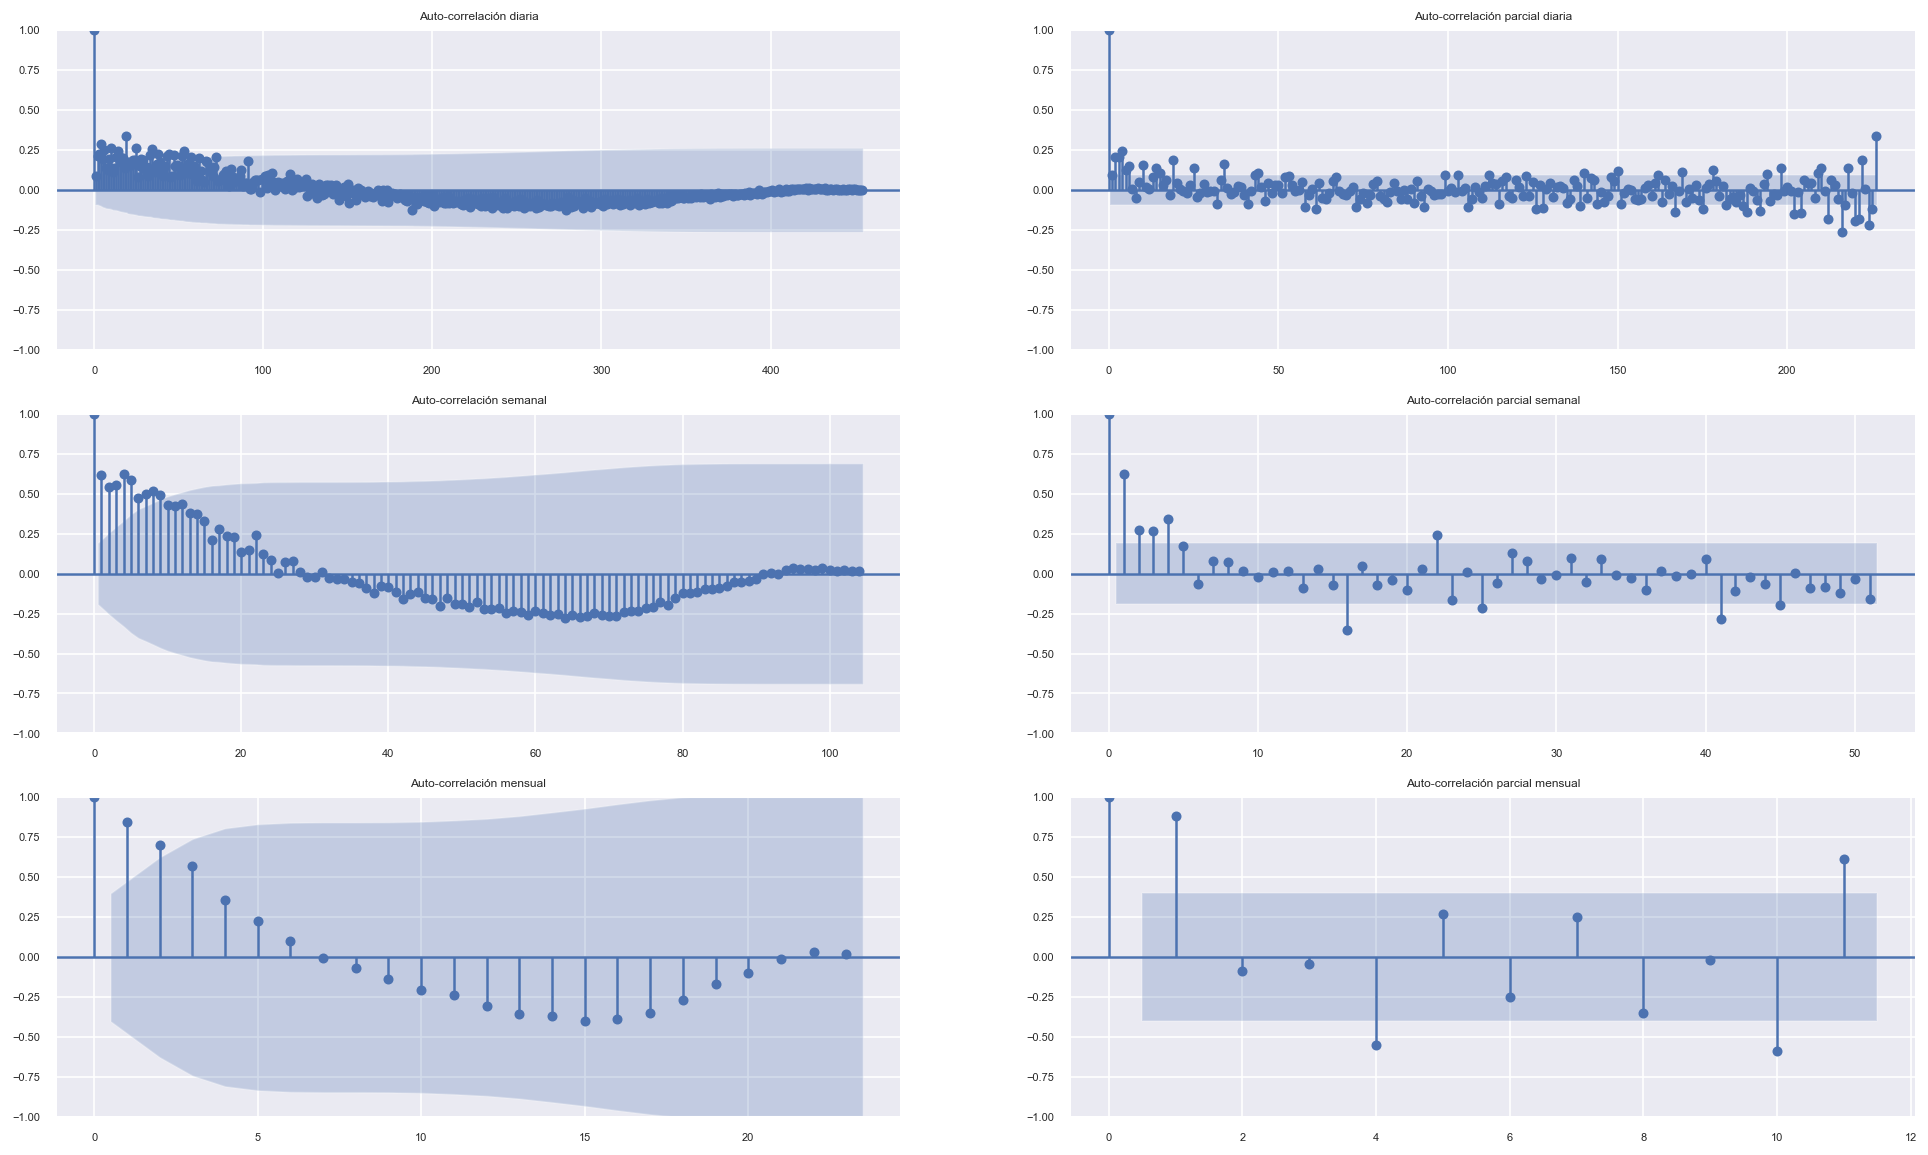

time: 1.11 s (started: 2022-03-12 17:16:20 -03:00)


In [66]:
fig, ax = plt.subplots(3, 2, figsize = (20, 12))
for i, ts in enumerate([series['total']['df']['kilos_sum'], weekly_series['total']['df']['kilos_sum'], monthly_series['total']['df']['kilos_sum']]):
    plot_acf(ts, ax=ax[i][0], lags=int(len(ts)) - 1)
    plot_pacf(ts, ax=ax[i][1], lags=int(len(ts)*.5) - 1)
ax[0][0].set_title('Auto-correlación diaria')
ax[0][1].set_title('Auto-correlación parcial diaria')
ax[1][0].set_title('Auto-correlación semanal')
ax[1][1].set_title('Auto-correlación parcial semanal')
ax[2][0].set_title('Auto-correlación mensual')
ax[2][1].set_title('Auto-correlación parcial mensual');

## Seasonal decomposition

In [70]:
dataframe = weekly_series['total']['series']['kilos_sum'].pd_dataframe()
weekWithZero = 0
for i in range(len(dataframe)):
    if (i + 1) not in dataframe.index:
        weekWithZero += 1
print(weekWithZero)

1
time: 0 ns (started: 2022-03-12 17:16:59 -03:00)


In [118]:
from statsmodels.stats.diagnostic import acorr_ljungbox

time: 0 ns (started: 2022-03-12 17:39:41 -03:00)


In [168]:
def plotSeasonalitySearch(serie, freqs, model_mode = ModelMode.ADDITIVE):
    bestFreq = 0
    bestScore = 0
    bestModels = (None, None, None)
    for freq in freqs:
        # Extraemos la tendencia y la estacionalidad
        trend, season = extract_trend_and_seasonality(serie, freq=freq, model=model_mode)
        # Calculamos los residuos
        residuals = remove_from_series(serie, trend, model_mode)
        residuals = remove_from_series(residuals, season, model_mode)
        # Analizamos la normalidad de los residuos
        k2, pvalue = normaltest(residuals.values())
        #ljung = acorr_ljungbox(residuals.values(), lags=10)
        #pvalue = ljung['lb_pvalue'].mean()
        if(pvalue > bestScore):
            bestScore = pvalue
            bestFreq = freq
            bestModels = (trend, season, residuals)
    trend, season, residuals = bestModels
    # Graficamos
    fig, ax = plt.subplots(3, 1, figsize = (15, 10), sharex=True)
    fig.suptitle(f'Best model for series, best freq: {bestFreq}, best score: {bestScore}')
    trend.plot(ax=ax[0])
    ax[0].set_title('Tendencia')
    season.plot(ax=ax[1])
    ax[1].set_title('Estacionalidad')
    residuals.plot(ax=ax[2])
    ax[2].set_title(f'Residuos')
    fig.autofmt_xdate()
    plt.tight_layout();
    return bestModels

time: 0 ns (started: 2022-03-12 18:07:34 -03:00)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


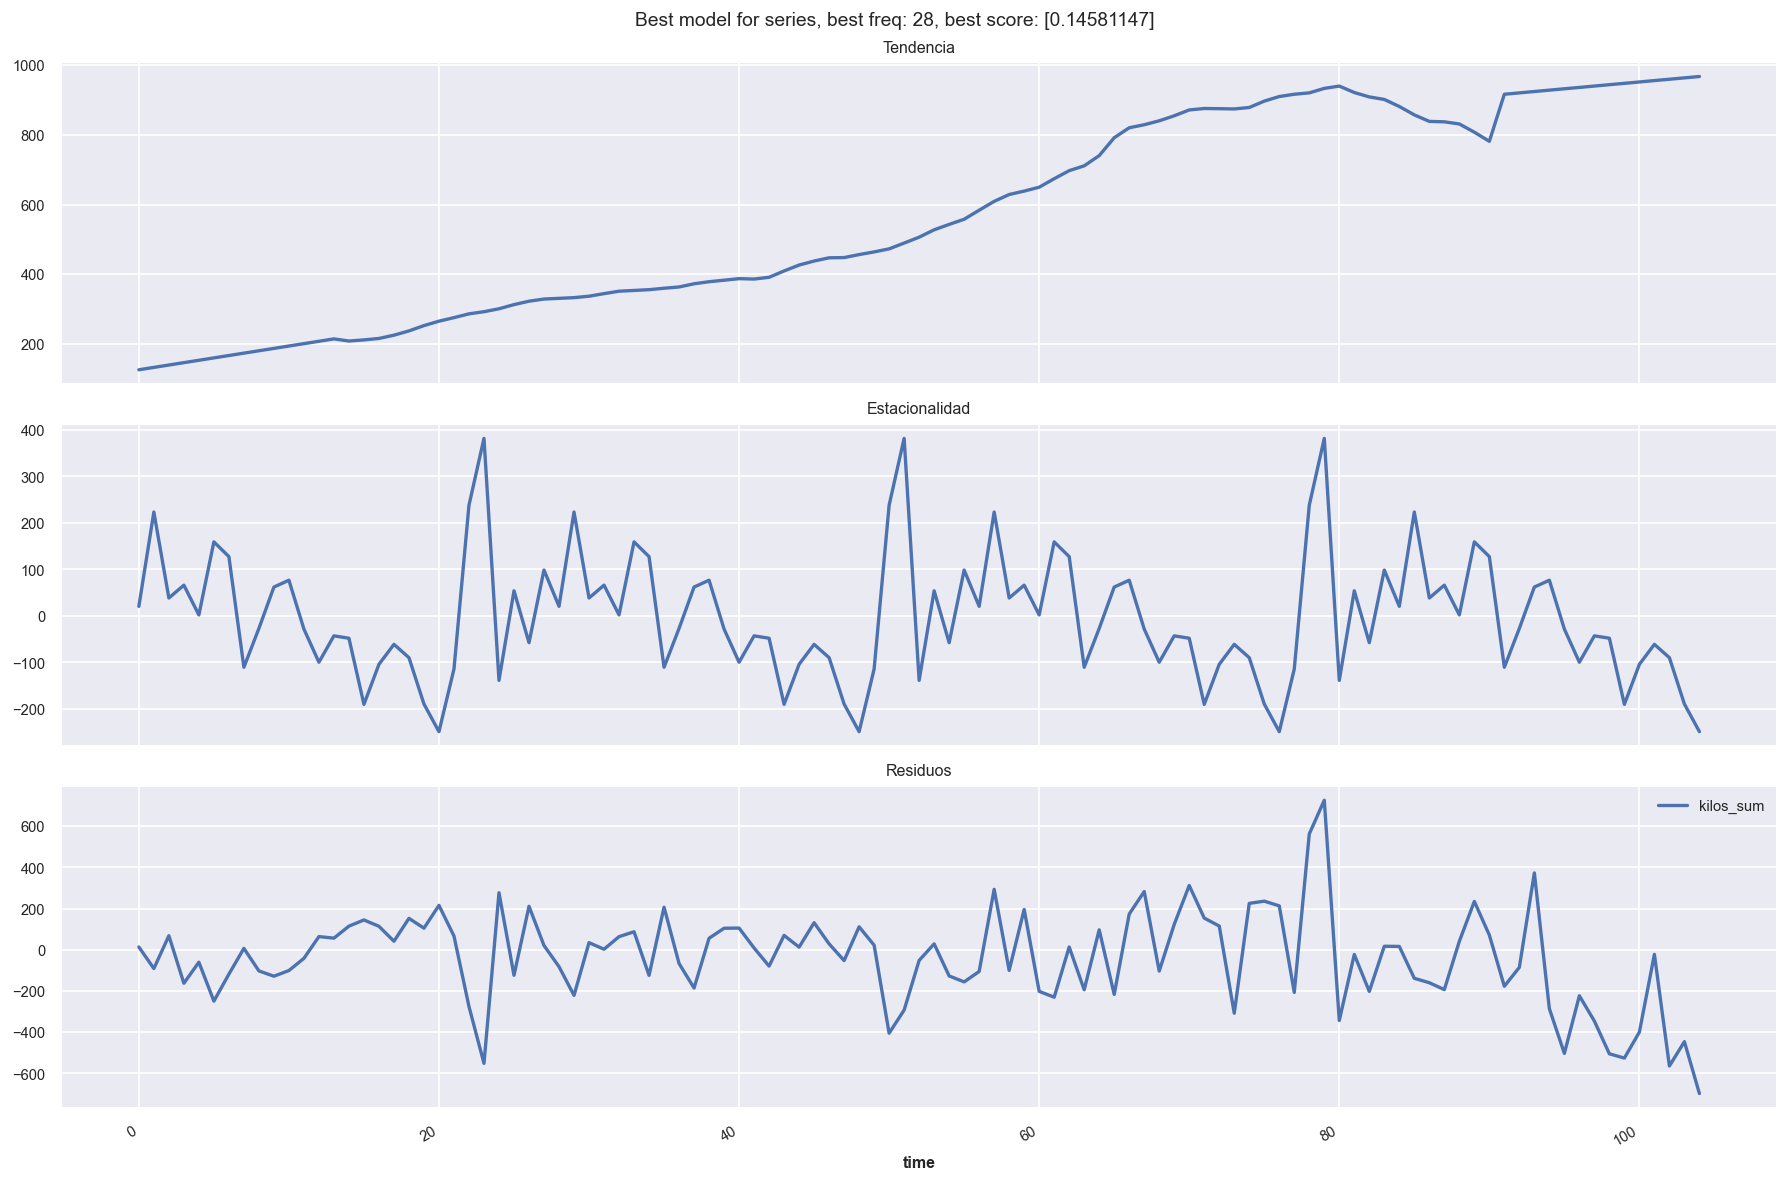

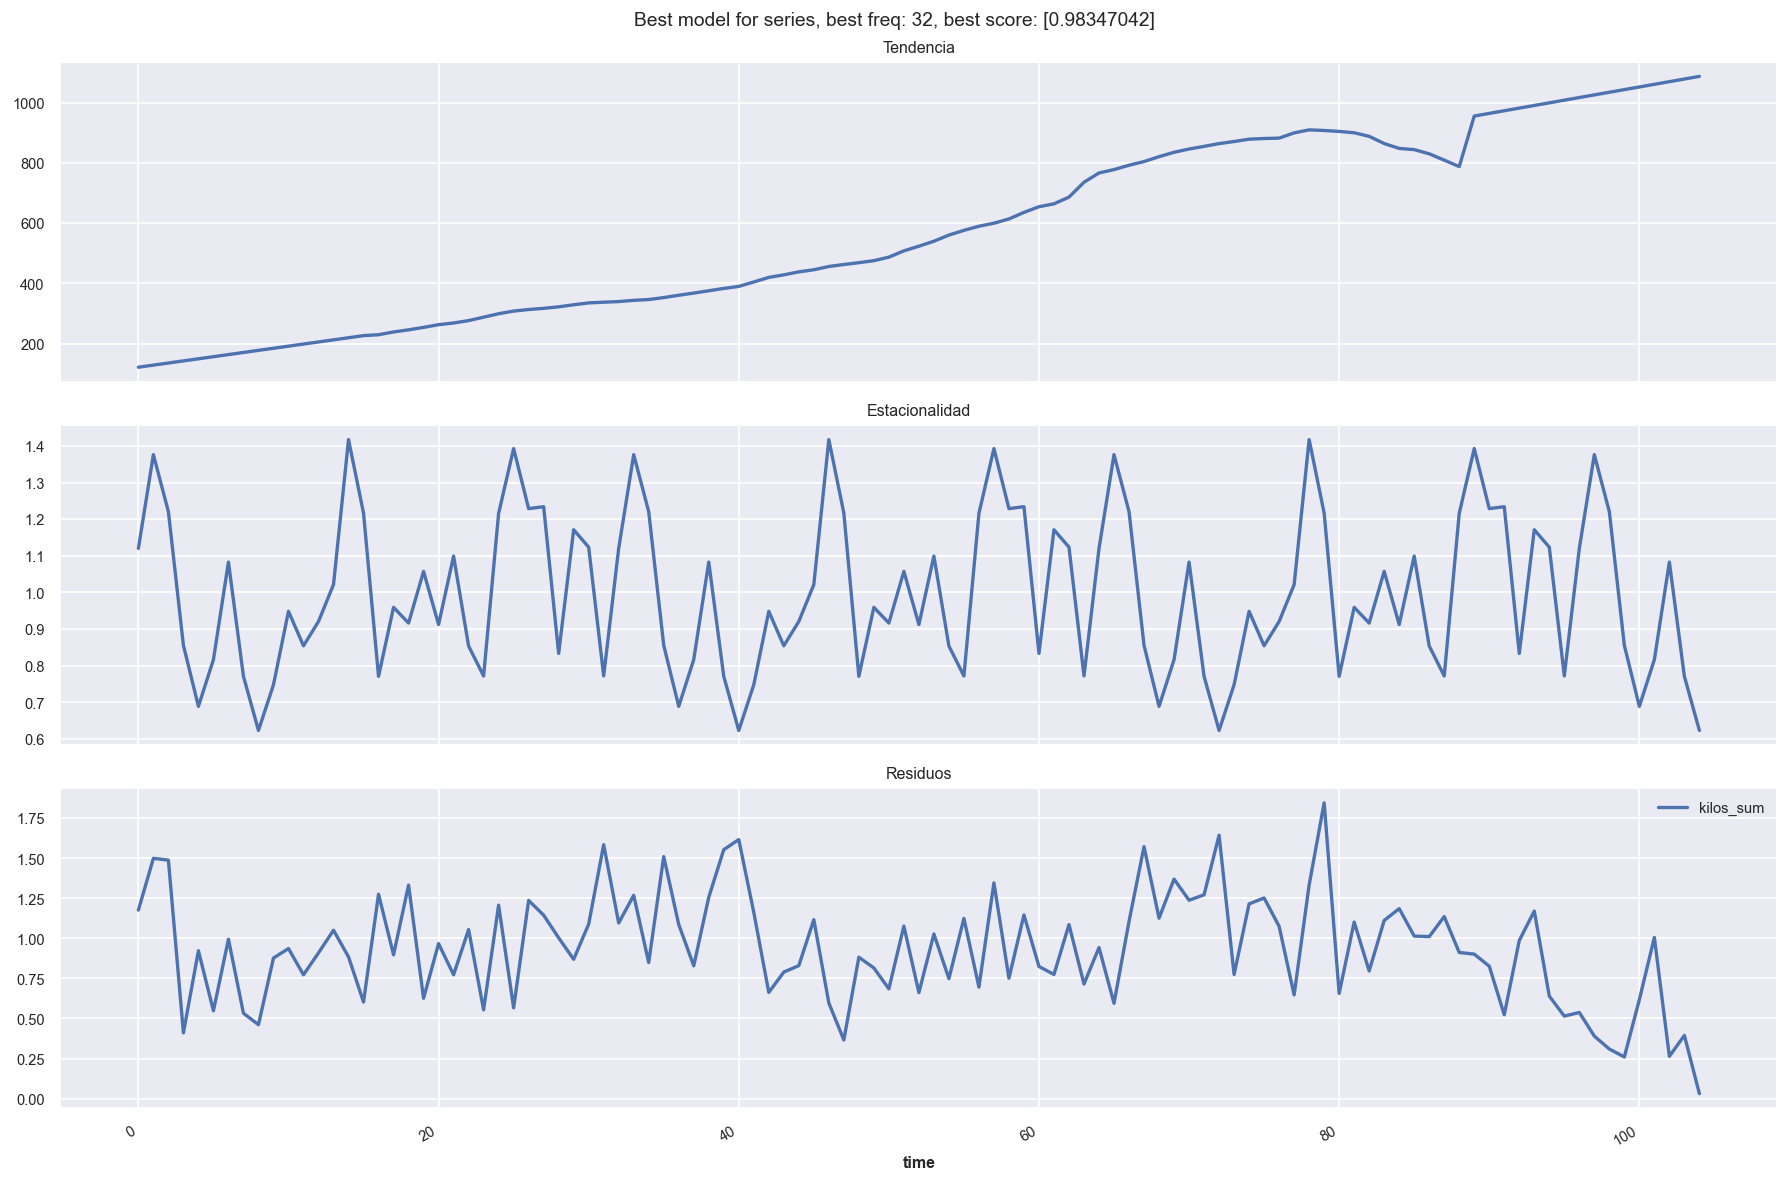

time: 1.58 s (started: 2022-03-12 18:07:36 -03:00)


In [169]:
# Buscamos la mejor frequencia para el modelo
trend, season, residuals = plotSeasonalitySearch(weekly_series['total']['series']['kilos_sum'], np.arange(1, 52), model_mode = ModelMode.ADDITIVE)
multiplicative_trend, multiplicative_season, multiplicative_residuals = plotSeasonalitySearch(weekly_series['total']['series']['kilos_sum'], np.arange(1, 52), model_mode = ModelMode.MULTIPLICATIVE)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


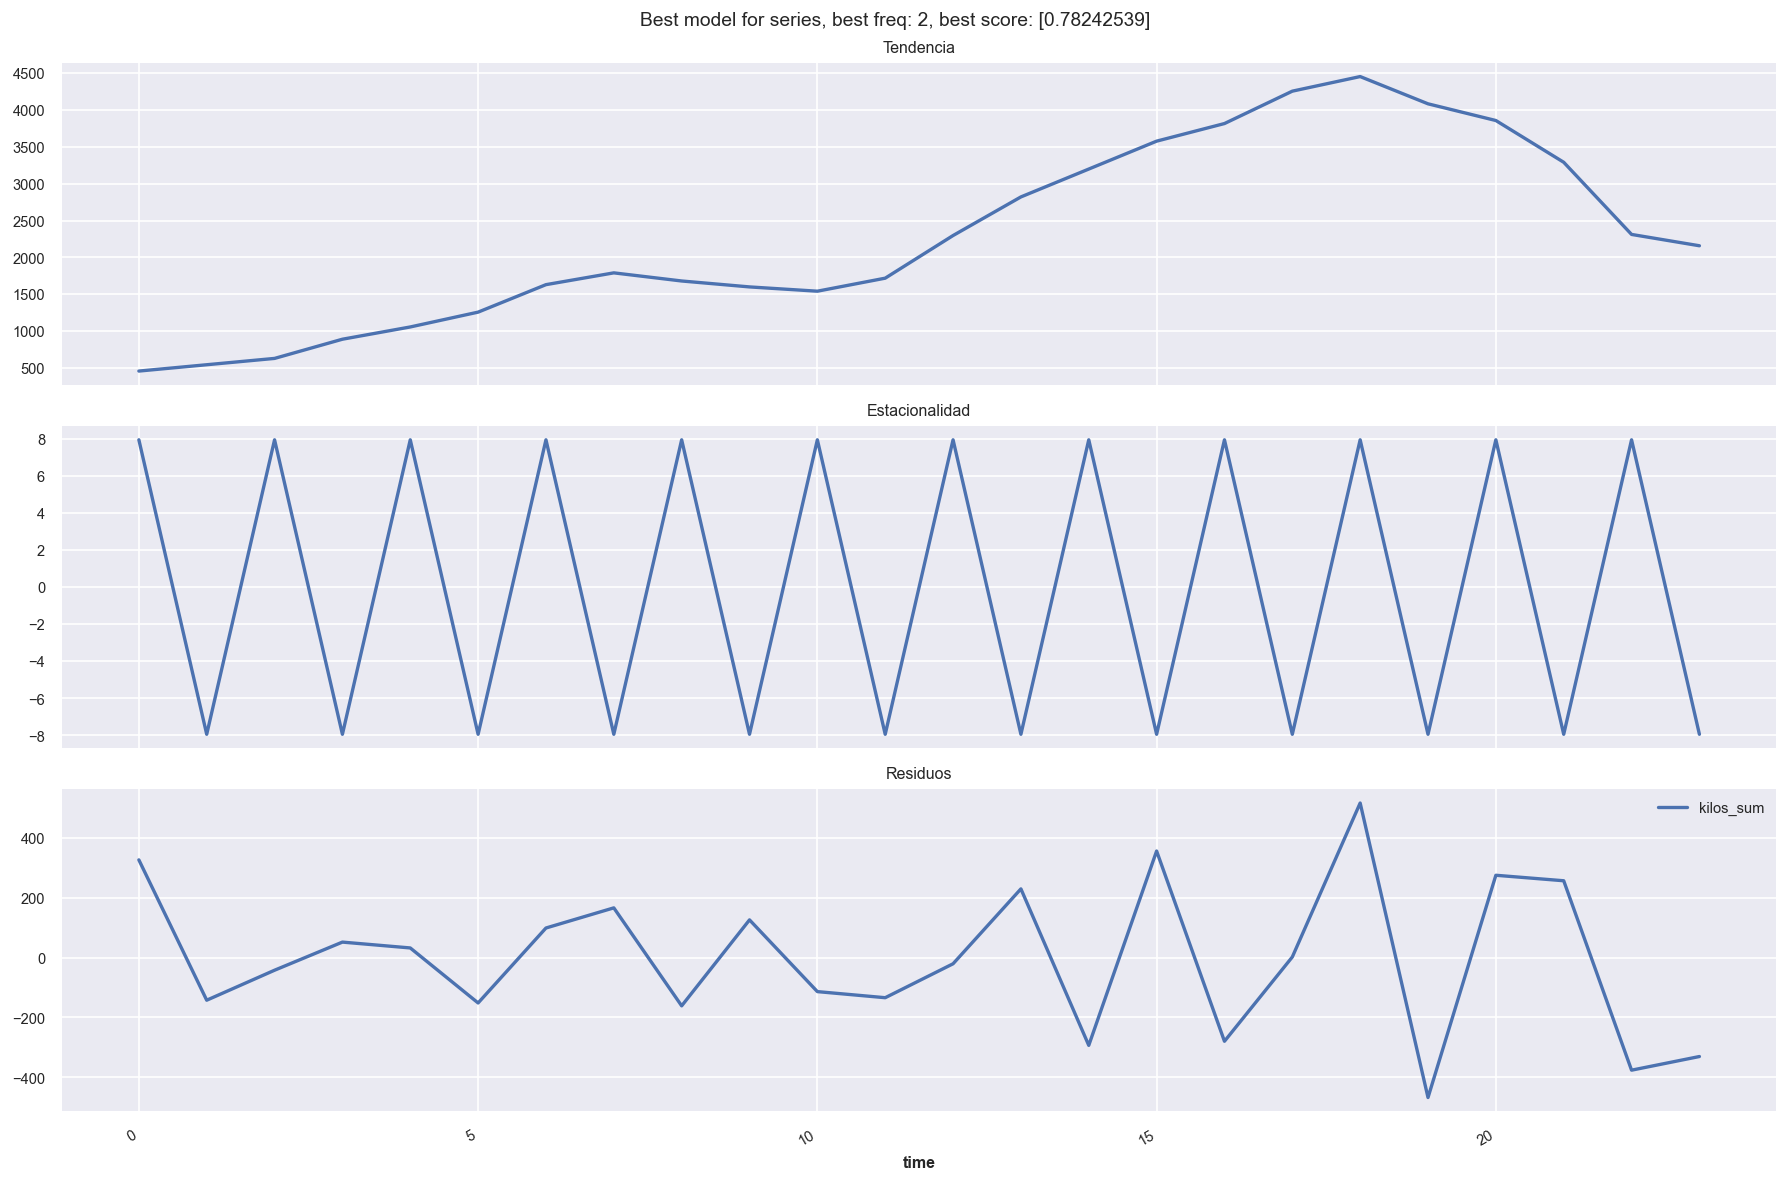

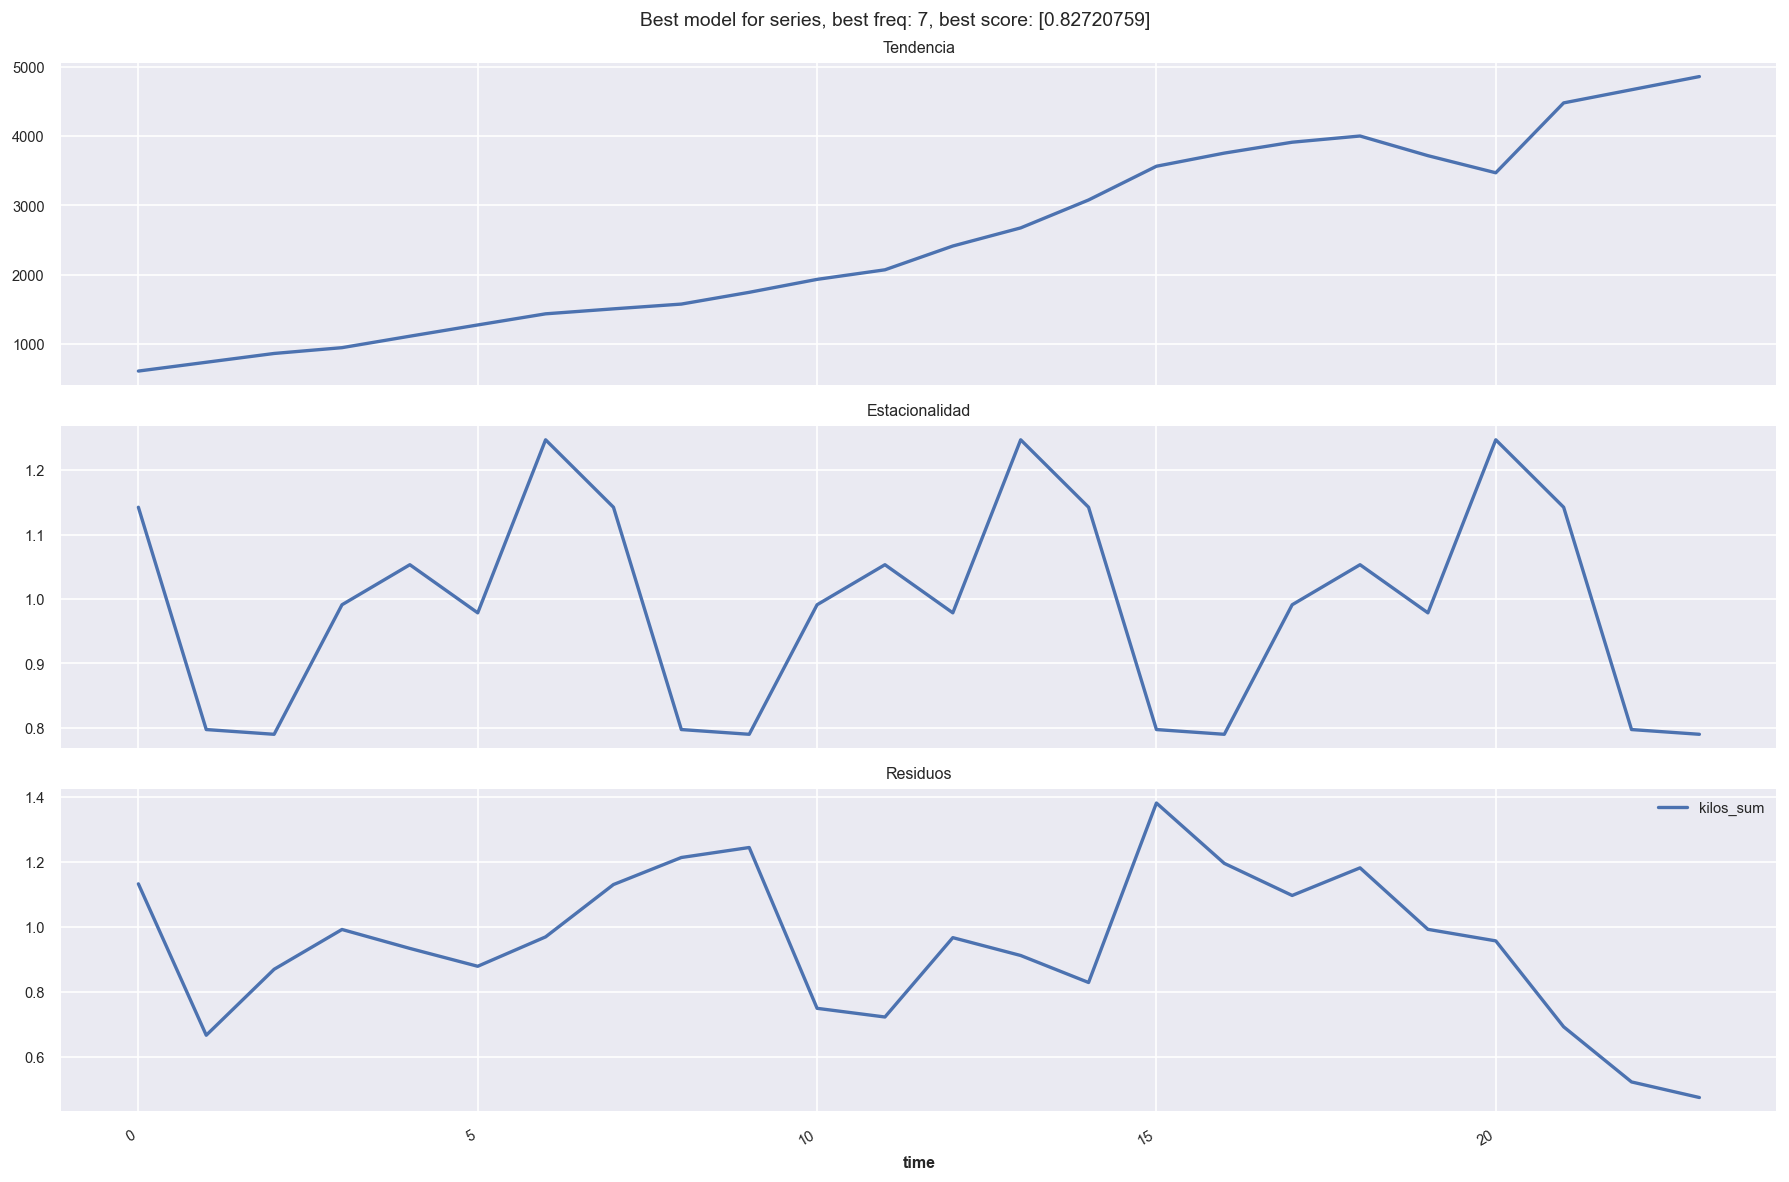

time: 1.09 s (started: 2022-03-12 18:07:41 -03:00)


In [170]:
monthly_trend, monthly_season, monthly_residuals = plotSeasonalitySearch(monthly_series['total']['series']['kilos_sum'], np.arange(1, 12), model_mode = ModelMode.ADDITIVE)
multiplicative_monthly_trend, multiplicative_monthly_season, multiplicative_monthly_residuals = plotSeasonalitySearch(monthly_series['total']['series']['kilos_sum'], np.arange(1, 12), model_mode = ModelMode.MULTIPLICATIVE)

Al realizar una descomposición de la serie de tiempo del producto 1 (temporalidad semanal), es posible ver la tendencia creciente de ventas en el periodo. Para continuar con el análisis, se elegirá uno de los lags ya visualizados en el gráfico de PACF para que esa serie sea el nuevo conjunto de datos. Se revisará cada producto para realizar la misma tarea.

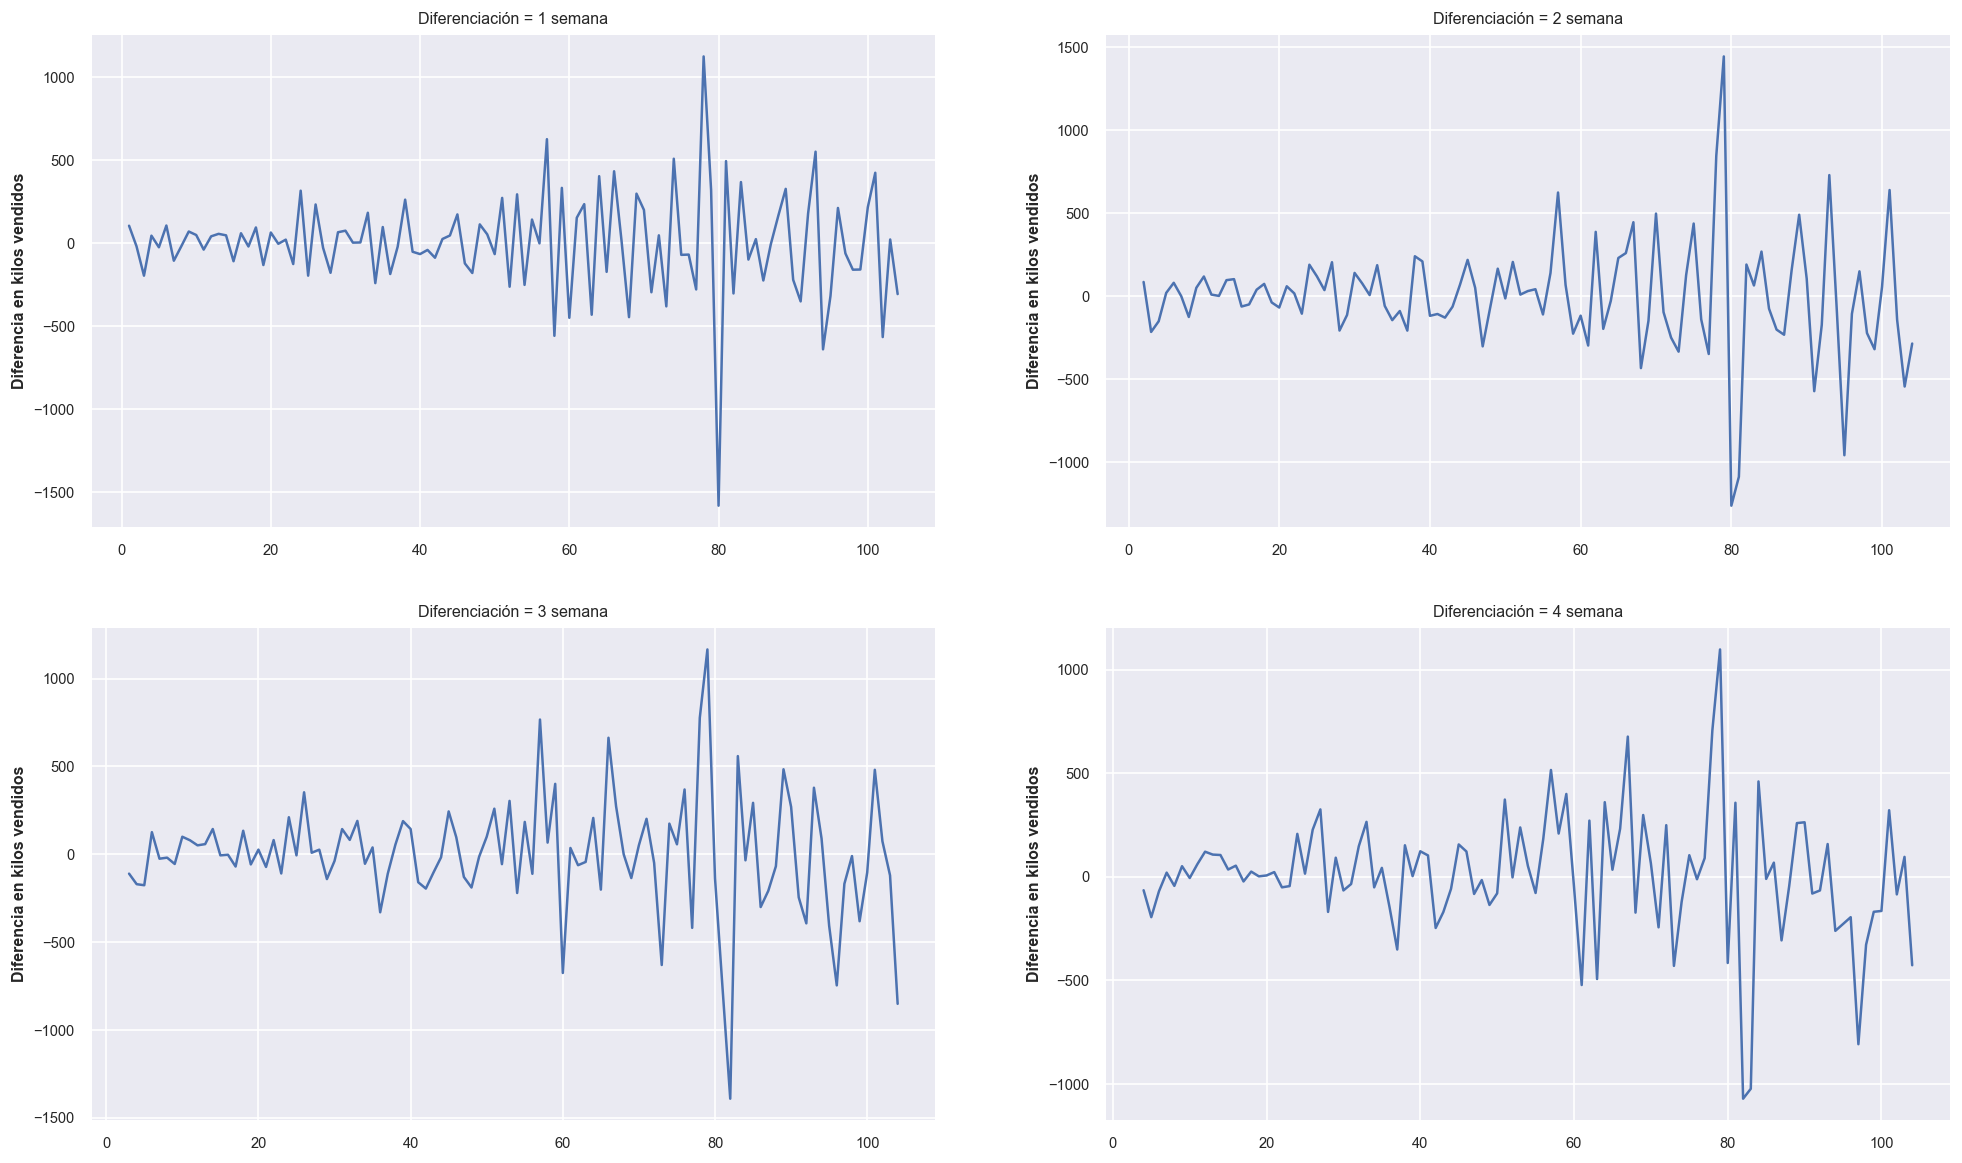

time: 578 ms (started: 2022-03-12 18:07:53 -03:00)


In [171]:
# lag = 1W, 2W, 3W, 4W
diffDf = weekly_series['total']['df'].copy()

diffDf['lag_1W'] = diffDf['kilos_sum'] - diffDf['kilos_sum'].shift(1)
diffDf['lag_2W'] = diffDf['kilos_sum'] - diffDf['kilos_sum'].shift(2)
diffDf['lag_3W'] = diffDf['kilos_sum'] - diffDf['kilos_sum'].shift(3)
diffDf['lag_4W'] = diffDf['kilos_sum'] - diffDf['kilos_sum'].shift(4)

sns.set(font_scale = 0.8)
fig, ax = plt.subplots(2, 2, figsize = (20, 12))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(diffDf.loc[(i + 1):, f'lag_{i + 1}W'])
    ax[i].set_title(f'Diferenciación = {i + 1} semana')
    ax[i].set_ylabel('Diferencia en kilos vendidos')

En este caso, al graficar la serie con lag de 1 semana, se observa que la curva ya no presenta la tendencia mostrada en la descomposición, por lo que esta serie será utilizada de aquí en adelante para la modelación. Sobre esta serie se chequea stationarity con el Augmented Dickey-Fuller Test.

In [76]:
from darts.utils.statistics import stationarity_test_adf

for i in range(5):
    diffSeries = weekly_series['total']['series']['kilos_sum'].diff(i + 1)
    adf_stats = stationarity_test_adf(diffSeries)
    print(f'Diferenciación = {i + 1} semana: ADF test: p-value = {adf_stats[1]}')
    print('='*15)

Diferenciación = 1 semana: ADF test: p-value = 5.450788284527847e-14
Diferenciación = 2 semana: ADF test: p-value = 1.0051389313053383e-10
Diferenciación = 3 semana: ADF test: p-value = 2.377279265147004e-09
Diferenciación = 4 semana: ADF test: p-value = 3.4733039804075344e-07
Diferenciación = 5 semana: ADF test: p-value = 8.665075020567468e-17
time: 63 ms (started: 2022-03-12 17:23:12 -03:00)


Es una serie estacionaria, con un intervalo de confianza de un 95%.

## Modelos

Luego de la exploración de atributos, hemos decidido testear con los siguiente modelos:

1. ARIMA
2. VARIMA
3. SARIMA
4. Exponential Smoothing
5. Kalman Forecaster
6. Regresión Lineal
7. Fast Fourier Transform
8. LSTM Y GRU
9. N-BEATS


### ARIMA

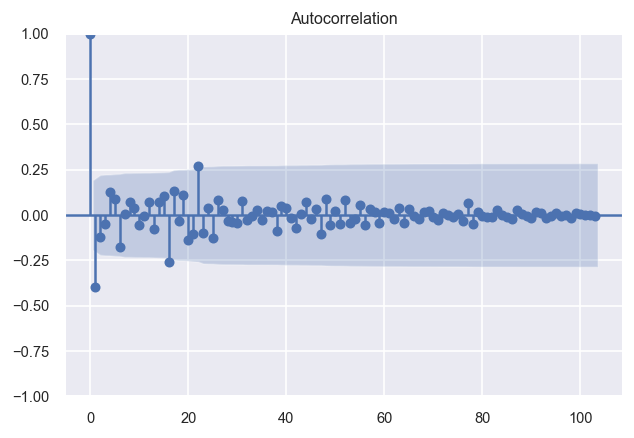

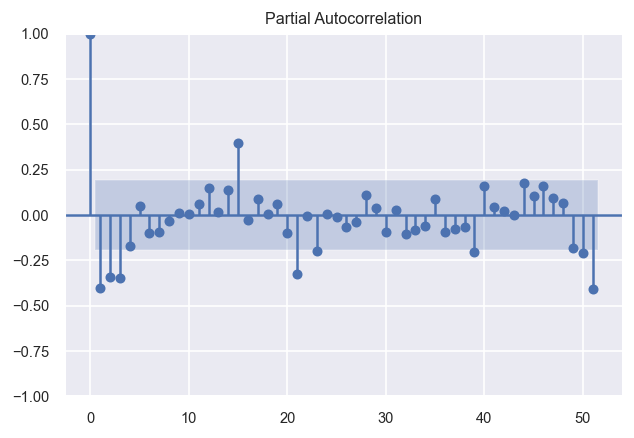

time: 343 ms (started: 2022-03-12 17:23:48 -03:00)


In [77]:
diff2 = weekly_series['total']['series']['kilos_sum'].diff(1).pd_dataframe()
plot_acf(diff2, lags=len(diff2) - 1);
plot_pacf(diff2, lags=int(len(diff2)*.5) - 1);

In [172]:
from darts.utils.model_selection import train_test_split
train, test = train_test_split(weekly_series['total']['series'], test_size=0.2)
print(len(train), len(test))

84 21
time: 0 ns (started: 2022-03-12 18:08:04 -03:00)


In [173]:
base_arima = ARIMA(p=9, d=2, q=0)
base_arima.fit(train['kilos_sum'], future_covariates=weekly_series['total']['series']['weekOfYear'])
preds = base_arima.predict(len(test['kilos_sum']), future_covariates=weekly_series['total']['series']['weekOfYear'])

time: 375 ms (started: 2022-03-12 18:08:06 -03:00)


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [174]:
test['kilos_sum'].pd_dataframe().sum() - preds.pd_dataframe().sum()

component
kilos_sum   -3695.370505
dtype: float64

time: 0 ns (started: 2022-03-12 18:08:08 -03:00)


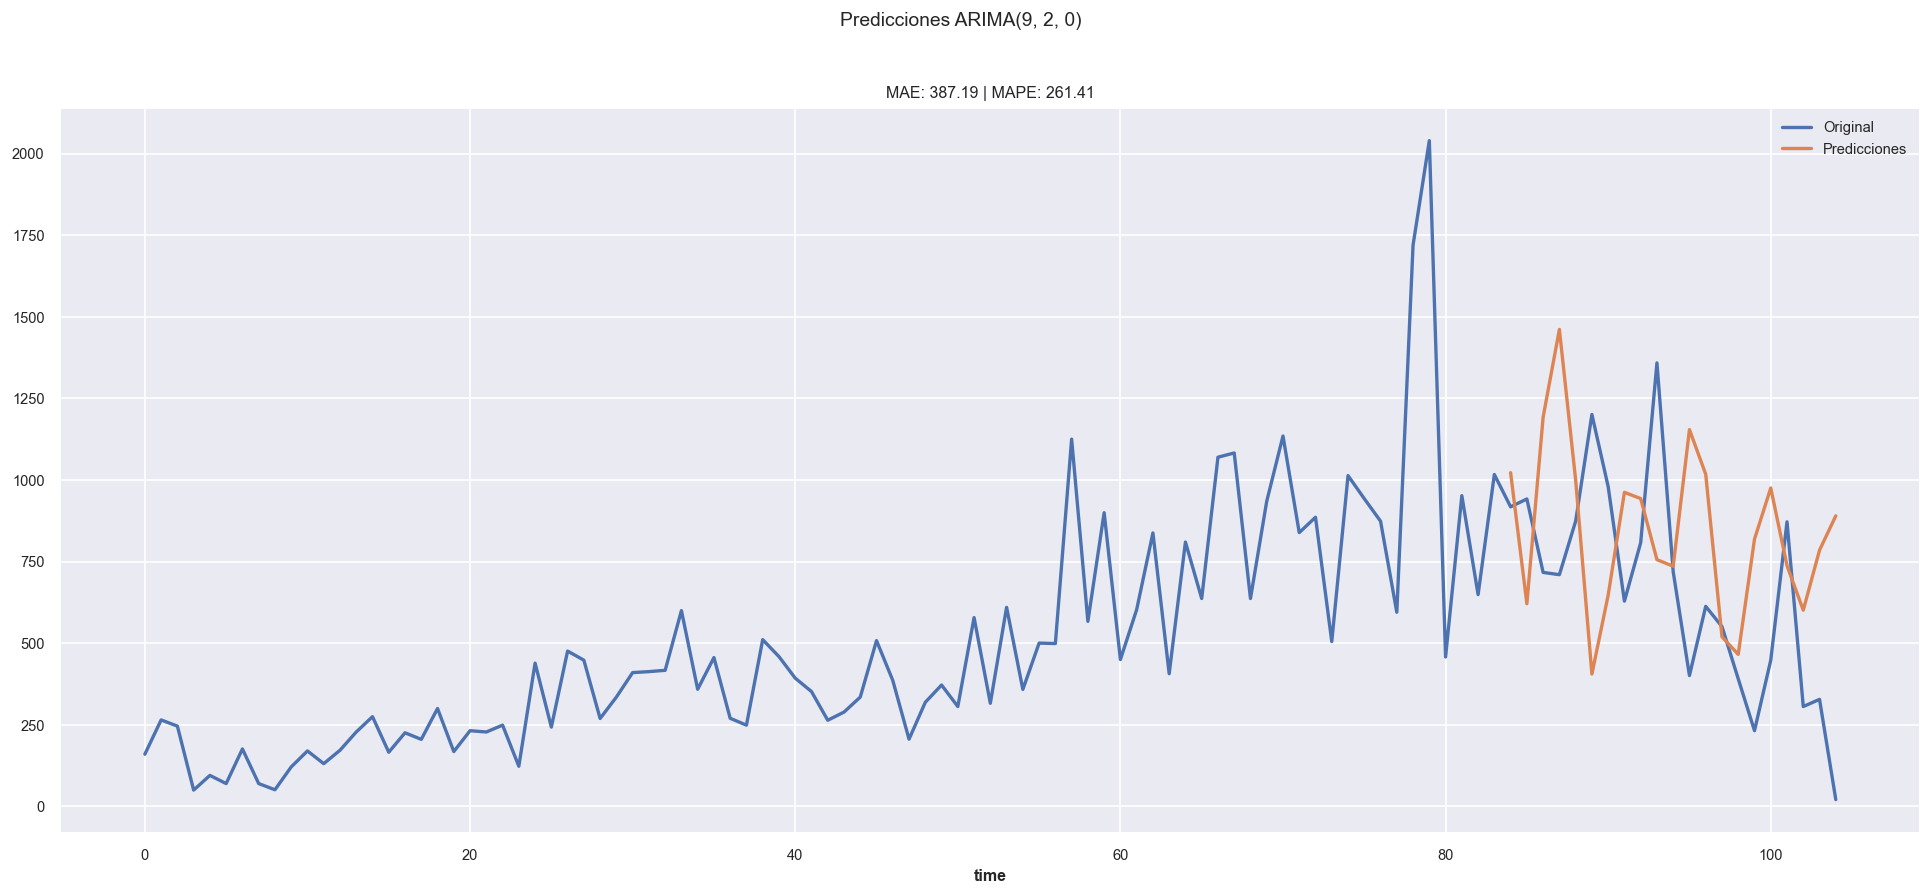

time: 297 ms (started: 2022-03-12 17:25:43 -03:00)


In [96]:
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], preds)
prediction_mape = mape(test['kilos_sum'], preds)
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
preds.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA(9, 2, 0)')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

In [97]:
pred = []
for i in range(len(test)):
    base_arima = ARIMA(p=9, d=2, q=0)
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    base_arima.fit(train_aux, future_covariates=weekly_series['total']['series']['weekOfYear'])
    preds = base_arima.predict(1, future_covariates=weekly_series['total']['series']['weekOfYear'])
    prediction = preds.values()[0]
    pred.append(prediction[0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test.pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


time: 7.3 s (started: 2022-03-12 17:25:50 -03:00)


In [98]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -715.550719
dtype: float64

time: 15 ms (started: 2022-03-12 17:25:57 -03:00)


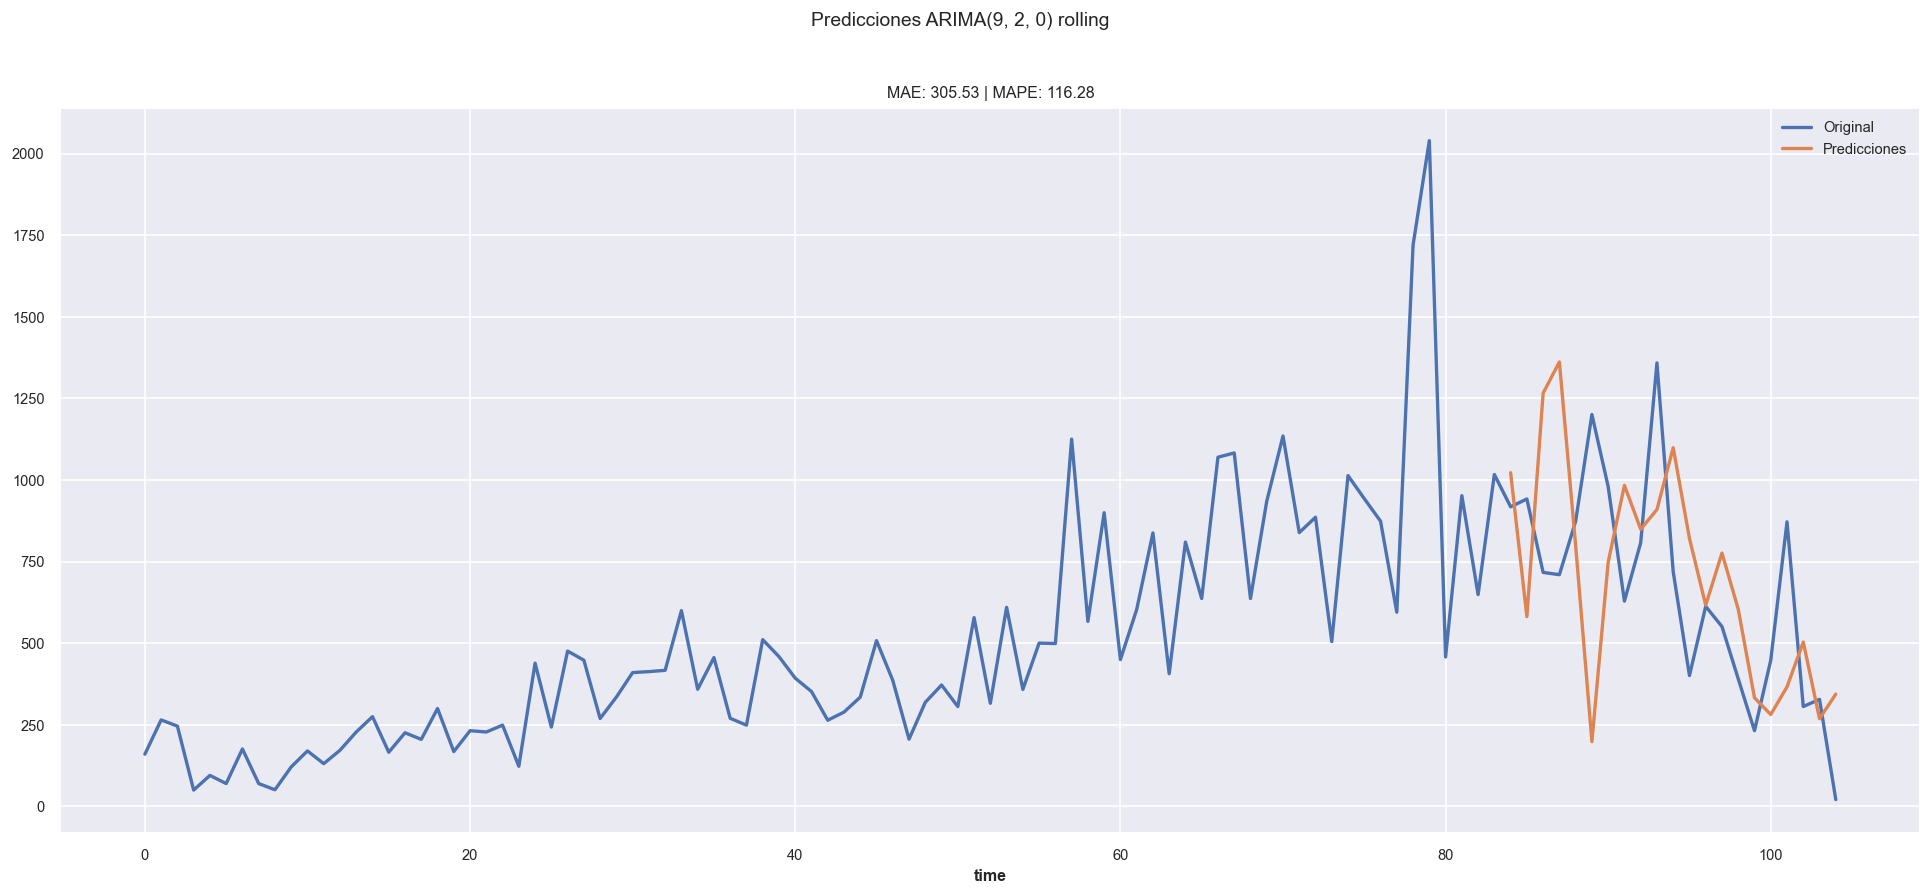

time: 312 ms (started: 2022-03-12 17:25:58 -03:00)


In [99]:
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA(9, 2, 0) rolling')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

In [100]:
pred = []
for i in range(len(test)):
    base_arima = ARIMA(p=2, d=2, q=0)
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    base_arima.fit(train_aux, future_covariates=weekly_series['total']['series']['weekOfYear'])
    preds = base_arima.predict(1, future_covariates=weekly_series['total']['series']['weekOfYear'])
    prediction = preds.values()[0]
    pred.append(prediction[0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test.pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)

time: 891 ms (started: 2022-03-12 17:27:21 -03:00)


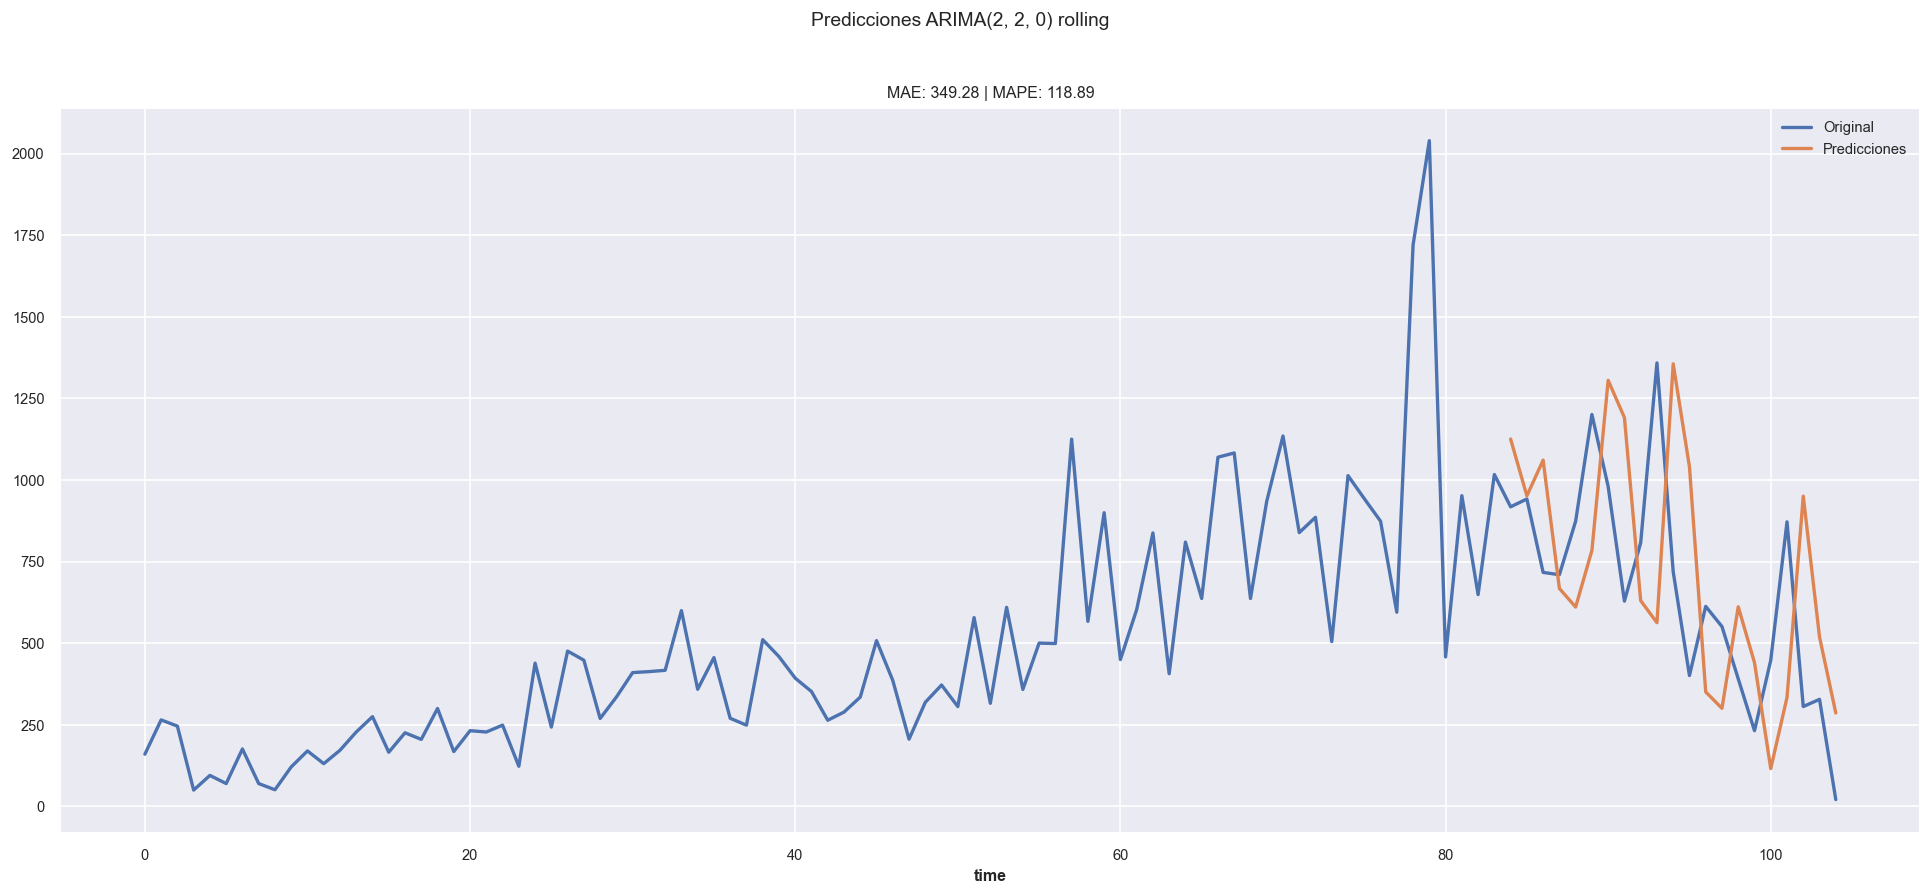

time: 313 ms (started: 2022-03-12 17:27:24 -03:00)


In [101]:
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA(2, 2, 0) rolling')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

In [102]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -1178.061703
dtype: float64

time: 0 ns (started: 2022-03-12 17:27:35 -03:00)


### SARIMA

### Regresión Lineal

In [103]:
from darts.models.forecasting.regression_model import RegressionModel

# Creamos una instancia de RegressionModel
pred = []
for i in range(0, len(test)):
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    regression = RegressionModel(lags=4)
    regression.fit(train_aux)
    # Predecimos
    predictions = regression.predict(1)
    # Guardamos la prediccion
    pred.append(predictions.values()[0][0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test['kilos_sum'].pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)

time: 156 ms (started: 2022-03-12 17:27:37 -03:00)


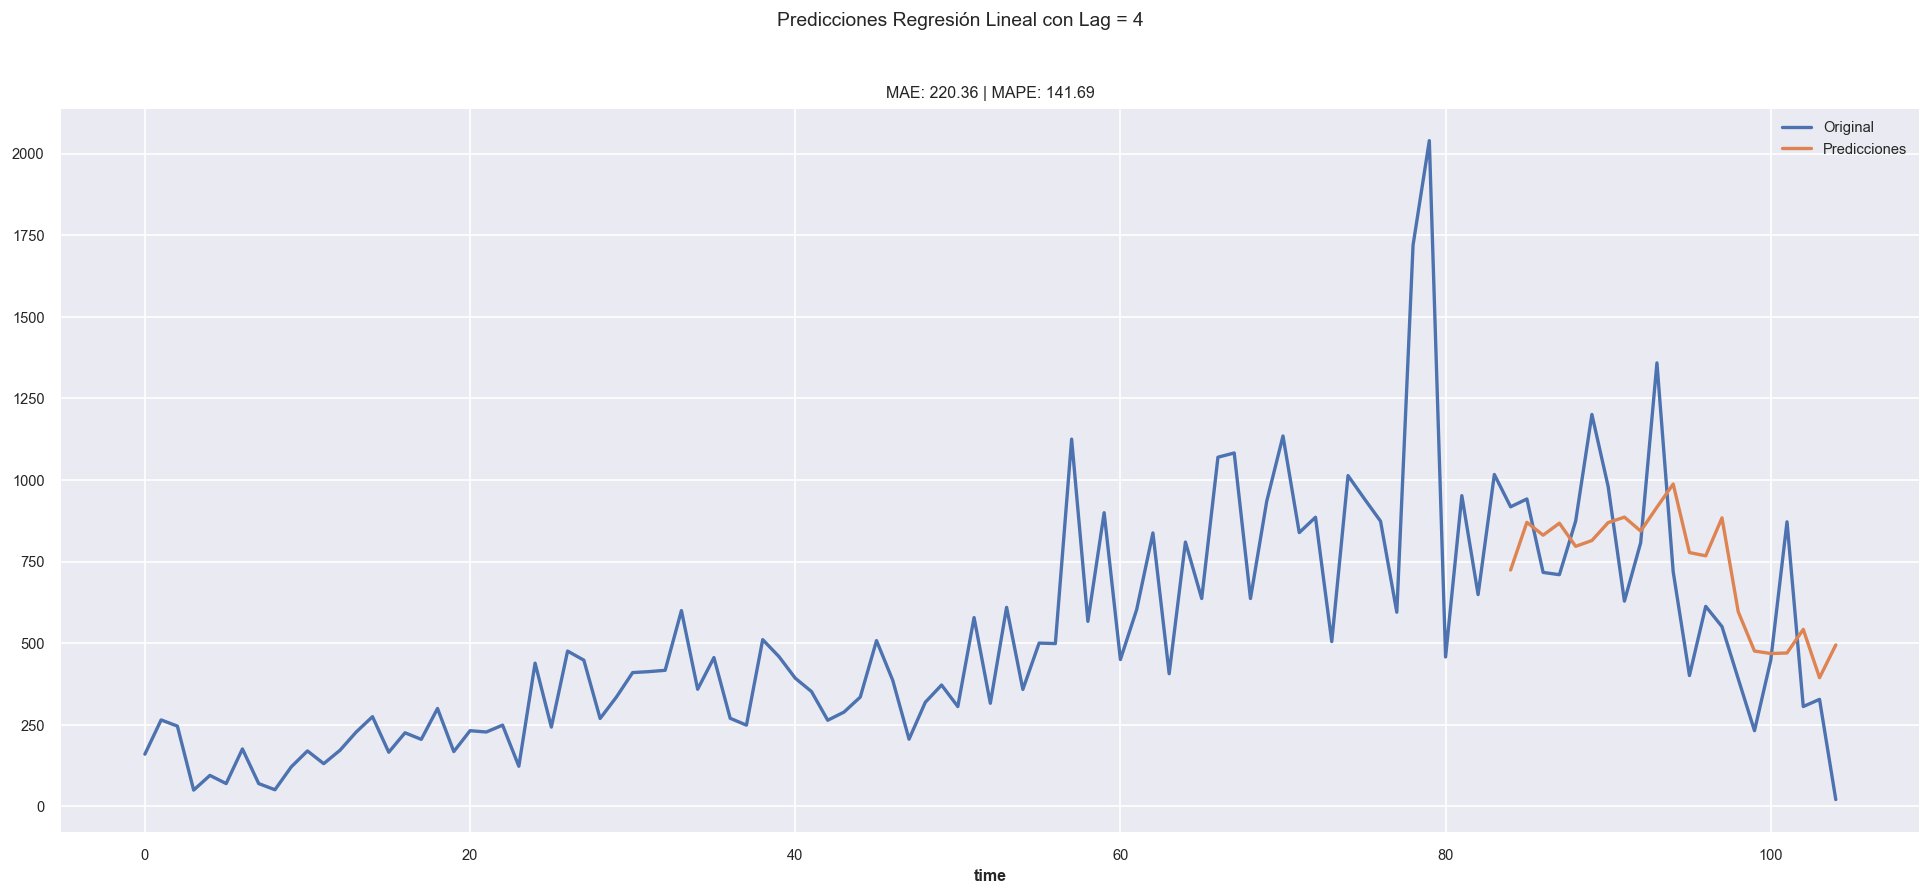

time: 281 ms (started: 2022-03-12 17:27:39 -03:00)


In [104]:
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones Regresión Lineal con Lag = 4')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

In [105]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -1261.903535
dtype: float64

time: 15 ms (started: 2022-03-12 17:27:51 -03:00)


### Fast Fourier Transform

In [106]:
from darts.models.forecasting.fft import FFT

# Creamos una instancia de RegressionModel
pred = []
for i in range(0, len(test)):
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    fft_model = FFT(trend='exp', nr_freqs_to_keep=26)
    fft_model.fit(train_aux)
    # Predecimos
    predictions = fft_model.predict(1)
    # Guardamos la prediccion
    pred.append(predictions.values()[0][0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test['kilos_sum'].pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)


time: 109 ms (started: 2022-03-12 17:28:03 -03:00)


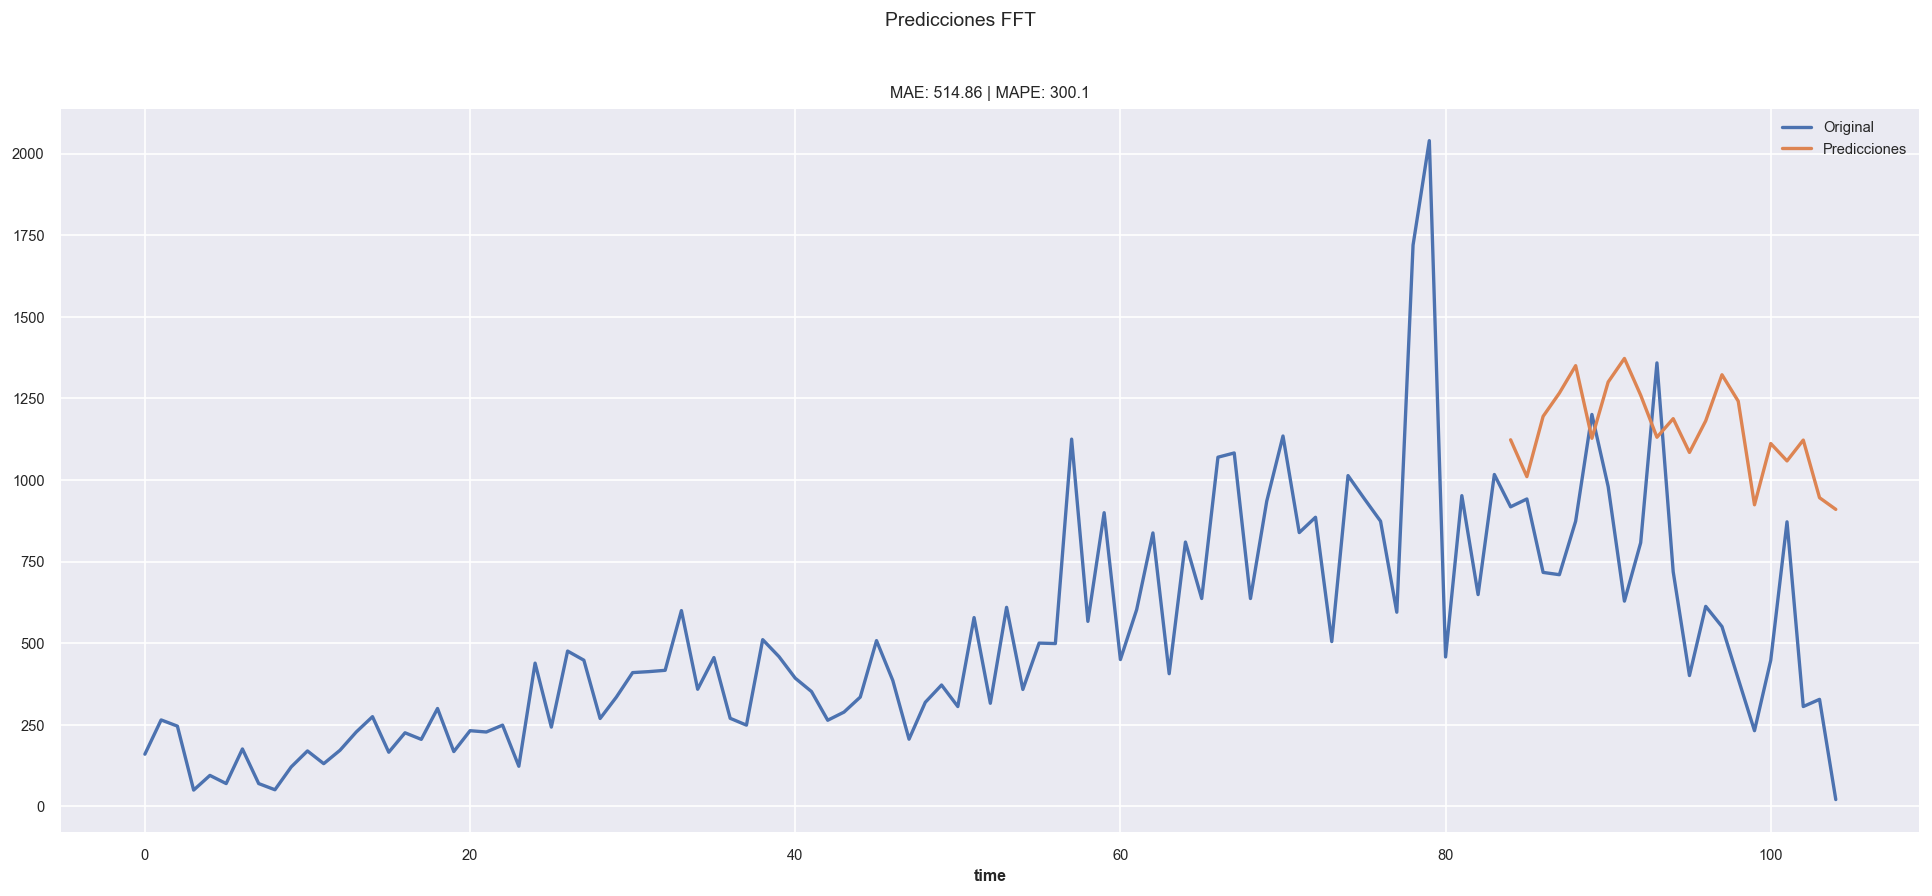

time: 281 ms (started: 2022-03-12 17:28:05 -03:00)


In [107]:
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones FFT')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

In [108]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -10210.147421
dtype: float64

time: 0 ns (started: 2022-03-12 17:28:07 -03:00)


### Recurrent Neural Nets

In [109]:
from darts.models.forecasting.rnn_model import RNNModel


time: 0 ns (started: 2022-03-12 17:28:21 -03:00)


In [117]:
lstm_model = RNNModel(input_chunk_length=4, n_rnn_layers=10, hidden_dim=200, dropout=0.3, batch_size=3, model='LSTM', training_length=12)
lstm_model.fit([weekly_series['total']['train']['target']], epochs=50, val_series=weekly_series['total']['test']['target'])
pred_val = lstm_model.predict(len(weekly_series['total']['test']['target']))

[2022-03-12 17:32:04,308] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 71 samples.
[2022-03-12 17:32:04,308] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 71 samples.
[2022-03-12 17:32:04,349] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-12 17:32:04,349] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | rnn       | LSTM    | 3.1 M 
2 | V         | Linear  | 201   
--------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
24.456    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 28/28 [00:04<00:00,  6.58it/s, loss=1.8e+05] 

[2022-03-12 17:35:14,909] ERROR | main_logger | ValueError: Input series has to be provided after fitting on multiple series.
[2022-03-12 17:35:14,909] ERROR | main_logger | ValueError: Input series has to be provided after fitting on multiple series.
[2022-03-12 17:35:14,909] ERROR | main_logger | ValueError: Input series has to be provided after fitting on multiple series.
[2022-03-12 17:35:14,909] ERROR | main_logger | ValueError: Input series has to be provided after fitting on multiple series.
[2022-03-12 17:35:14,909] ERROR | main_logger | ValueError: Input series has to be provided after fitting on multiple series.


ValueError: Input series has to be provided after fitting on multiple series.

time: 3min 10s (started: 2022-03-12 17:32:04 -03:00)


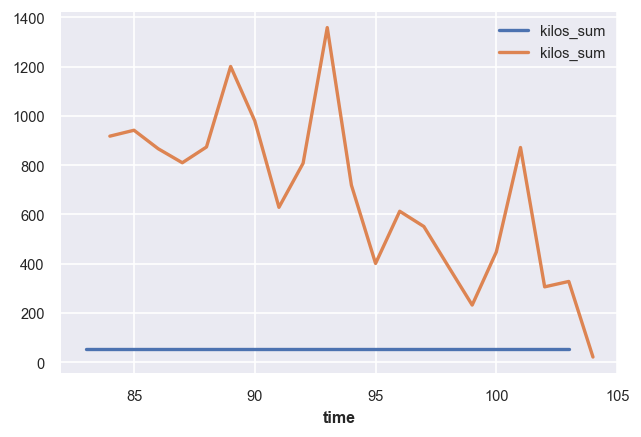

time: 187 ms (started: 2022-03-12 12:33:20 -03:00)


In [ ]:
pred_val.plot()
test['kilos_sum'].plot()

In [ ]:
gru_model = RNNModel(input_chunk_length=12, n_rnn_layers=2, hidden_dim=50, dropout=0.1, model='GRU', training_length=18)
gru_model.fit(weekly_series['total']['train']['target'], epochs=200, val_series=weekly_series['total']['test']['target'], verbose=True)
pred_val = gru_model.predict(len(test))

[2022-03-12 11:53:49,114] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 65 samples.
[2022-03-12 11:53:49,114] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 65 samples.
[2022-03-12 11:53:49,118] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-12 11:53:49,118] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-12 11:53:49,120] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-12 11:53:49,120] WARNING | darts.models.forecasting.torch_forecasting_model | Deprecati

Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 52.42it/s, loss=2.64e+05]
Predicting: 3it [00:00, ?it/s]
time: 14.8 s (started: 2022-03-12 11:53:49 -03:00)


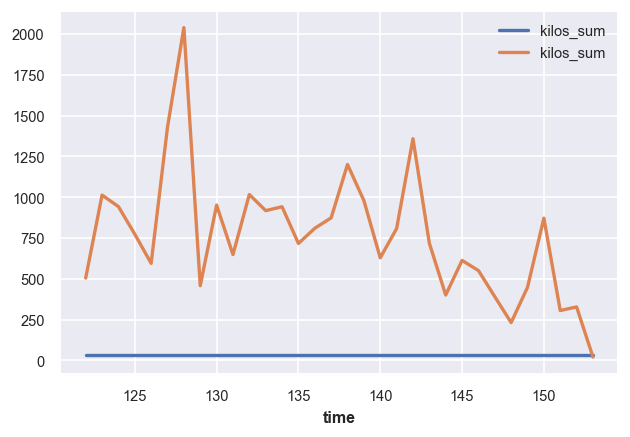

time: 203 ms (started: 2022-03-12 10:48:07 -03:00)


In [ ]:
pred_val.plot()
test['kilos_sum'].plot()

In [ ]:
rnn_model = RNNModel(input_chunk_length=12, n_rnn_layers=2, hidden_dim=50, dropout=0.1, model='RNN', training_length=27)
rnn_model.fit(weekly_series['total']['train']['target'], epochs=200, val_series=weekly_series['total']['test']['target'], verbose=True)
pred_val = rnn_model.predict(len(test))

[2022-03-12 10:48:07,466] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 95 samples.
[2022-03-12 10:48:07,466] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 95 samples.
[2022-03-12 10:48:07,469] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-12 10:48:07,469] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-12 10:48:07,471] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-12 10:48:07,471] WARNING | darts.models.forecasting.torch_forecasting_model | Deprecati

Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 64.69it/s, loss=8.16e+04]
Predicting: 3it [00:00, ?it/s]
time: 11.1 s (started: 2022-03-12 10:48:07 -03:00)


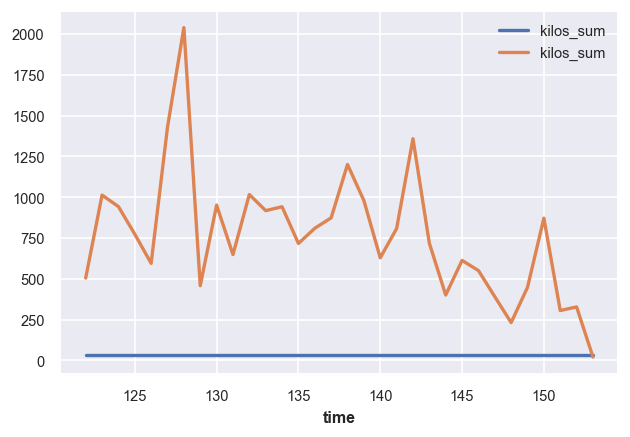

time: 188 ms (started: 2022-03-12 10:48:18 -03:00)


In [ ]:
pred_val.plot()
test['kilos_sum'].plot()

Fuentes:
    
1. https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
2. https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=A%20time%20series%20may%20be,other%20values%20in%20the%20series.
3. https://medium.com/data-science-in-your-pocket/preprocessing-for-time-series-forecasting-3a331dbfb9c2
4. https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
5.http://recursostic.educacion.es/descartes/web/materiales_didacticos/unidimensional_lbarrios/asimetria_est.htm
6. 